<a href="https://colab.research.google.com/github/LojanoE/practicas-finales-ml-u3-u4/blob/main/Copy_of_Random_Forests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# En profundidad: Árboles de decisión y bosques aleatorios

Anteriormente hemos analizado en profundidad un clasificador generativo simple (Naive Bayes; ver En profundidad: Clasificación Naive Bayes) y un potente clasificador discriminativo (máquinas de vectores de soporte; ver En profundidad: Máquinas de Vectores de Soporte).

Aquí echaremos un vistazo a otro algoritmo potente: un algoritmo no paramétrico llamado bosques aleatorios (random forests).
Los bosques aleatorios son un ejemplo de un método de ensamble, lo que significa que se basa en agregar los resultados de un conjunto de estimadores más simples. El resultado algo sorprendente con tales métodos de ensamble es que la suma puede ser mayor que las partes: es decir, ¡la precisión predictiva de un voto por mayoría entre varios estimadores puede resultar mejor que la de cualquiera de los estimadores individuales que emiten el voto! Veremos ejemplos de esto en las siguientes secciones.

Comenzamos con las importaciones estándar:

In [ ]:
#pip install seaborn
import seaborn as sns

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
#plt.style.use('seaborn-whitegrid')
sns.set_style("whitegrid")

## Motivación de los bosques aleatorios: Árboles de decisión

Los bosques aleatorios son un ejemplo de un método de aprendizaje de conjunto (ensemble) construido sobre árboles de decisión. Por esta razón, comenzaremos analizando los árboles de decisión en sí mismos.

Los árboles de decisión son formas extremadamente intuitivas de clasificar o etiquetar objetos: simplemente se hace una serie de preguntas diseñadas para determinar la clasificación. Por ejemplo, si quisieras construir un árbol de decisión para clasificar los animales que te encuentras durante una caminata, podrías construir el que se muestra en la siguiente figura.

![](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/images/05.08-decision-tree.png?raw=1)
[figure source in Appendix](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/06.00-Figure-Code.ipynb#Decision-Tree-Example)

La división binaria hace que esto sea extremadamente eficiente: en un árbol bien construido, cada pregunta reducirá el número de opciones aproximadamente a la mitad, acotando muy rápidamente las opciones incluso entre un gran número de clases.
El truco, por supuesto, está en decidir qué preguntas formular en cada paso.
En las implementaciones de árboles de decisión en aprendizaje automático (*machine learning*), las preguntas generalmente toman la forma de divisiones alineadas con los ejes en los datos: es decir, cada nodo en el árbol divide los datos en dos grupos utilizando un valor de corte dentro de una de las características.
Veamos ahora un ejemplo de esto.

### Crear un arbol de descición

Considera los siguientes datos bidimensionales, que tienen una de cuatro etiquetas de clase (ver la siguiente figura):

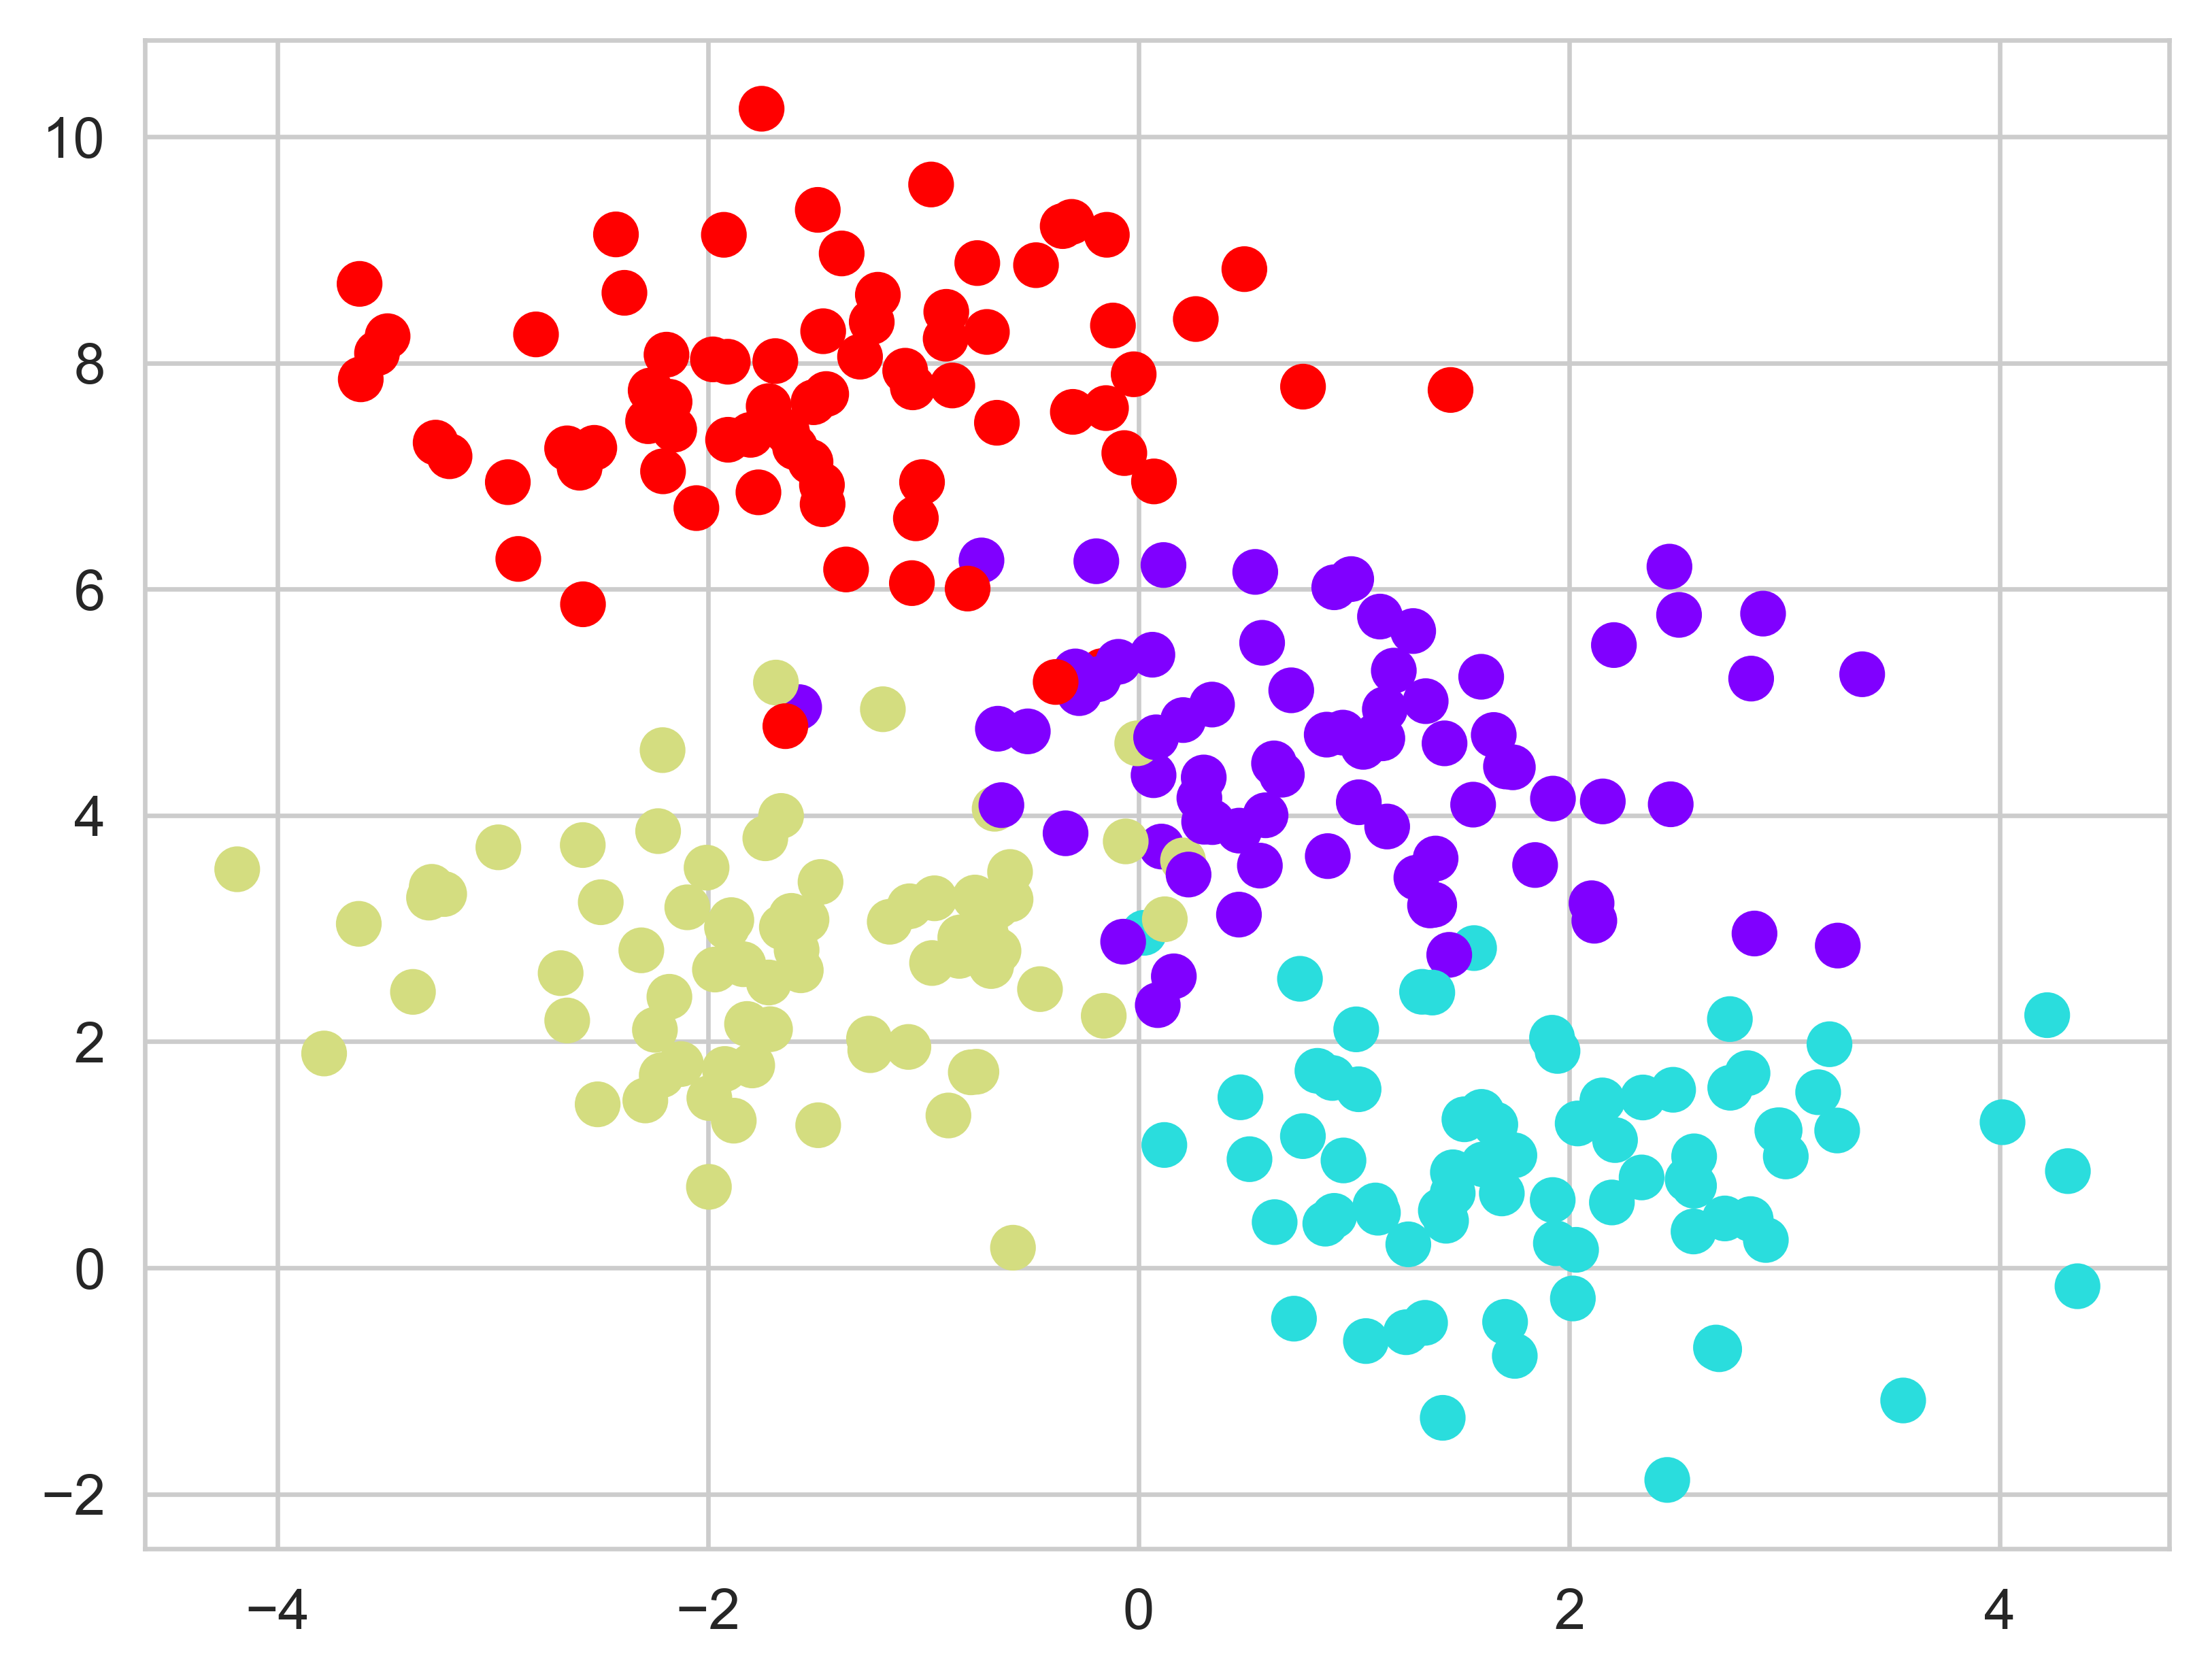

In [4]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=1.0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow');

Un árbol de decisión simple construido sobre estos datos dividirá iterativamente los datos a lo largo de uno u otro eje según algún criterio cuantitativo y, en cada nivel, asignará la etiqueta de la nueva región de acuerdo con un voto por mayoría de los puntos dentro de ella.

La siguiente figura presenta una visualización de los primeros cuatro niveles de un clasificador de árbol de decisión para estos datos.



![](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/images/05.08-decision-tree-levels.png?raw=1)
[figure source in Appendix](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/06.00-Figure-Code.ipynb#Decision-Tree-Levels)

Observa que después de la primera división, cada punto en la rama superior permanece inalterado, por lo que no es necesario subdividir más esta rama.
A excepción de los nodos que contienen todo de un mismo color, en cada nivel *cada* región se divide nuevamente a lo largo de una de las dos características.

Este proceso de ajustar un árbol de decisión a nuestros datos se puede realizar en Scikit-Learn con el estimador ``DecisionTreeClassifier``:

In [5]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier().fit(X, y)

Escribamos una función de utilidad para ayudarnos a visualizar la salida del clasificador:

In [6]:
def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
    ax = ax or plt.gca()

    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap,
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # fit the estimator
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, zorder=1)

    ax.set(xlim=xlim, ylim=ylim)

Ahora podemos examinar cómo se ve la clasificación del árbol de decisión (ver la siguiente figura):



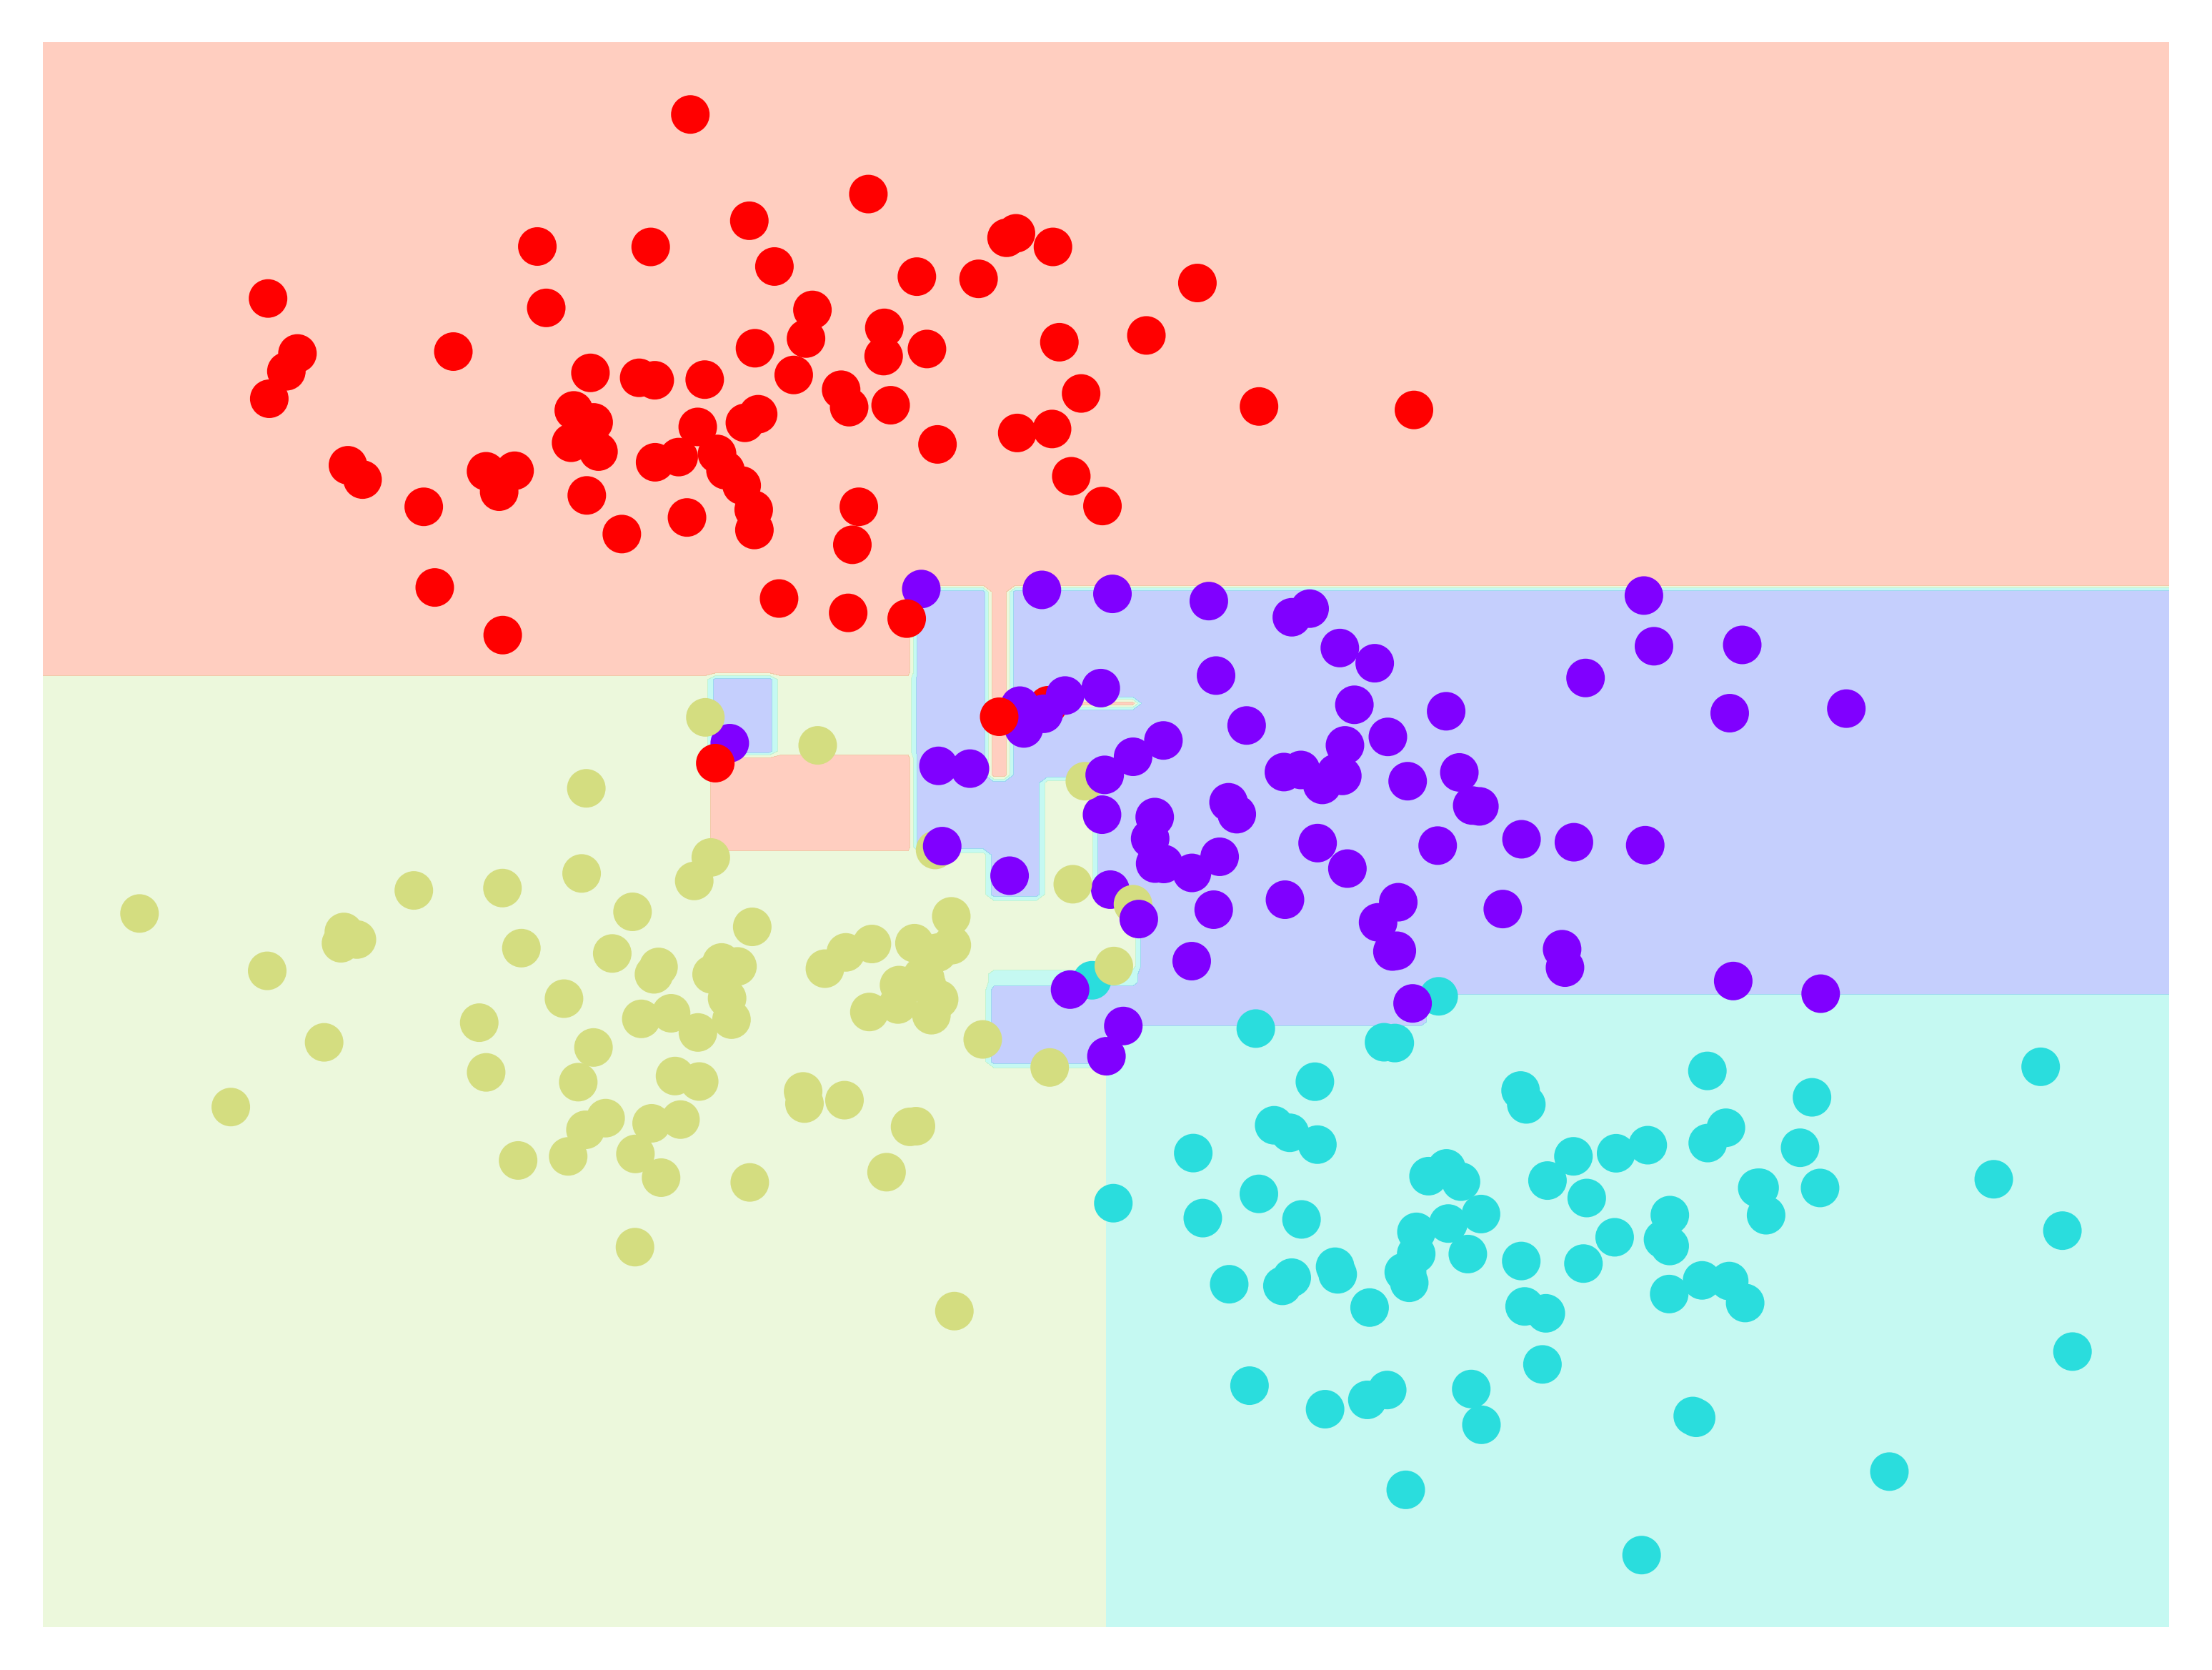

In [7]:
visualize_classifier(DecisionTreeClassifier(), X, y)

interactive(children=(IntSlider(value=5, description='depth', max=5, min=1), Output()), _dom_classes=('widget-…

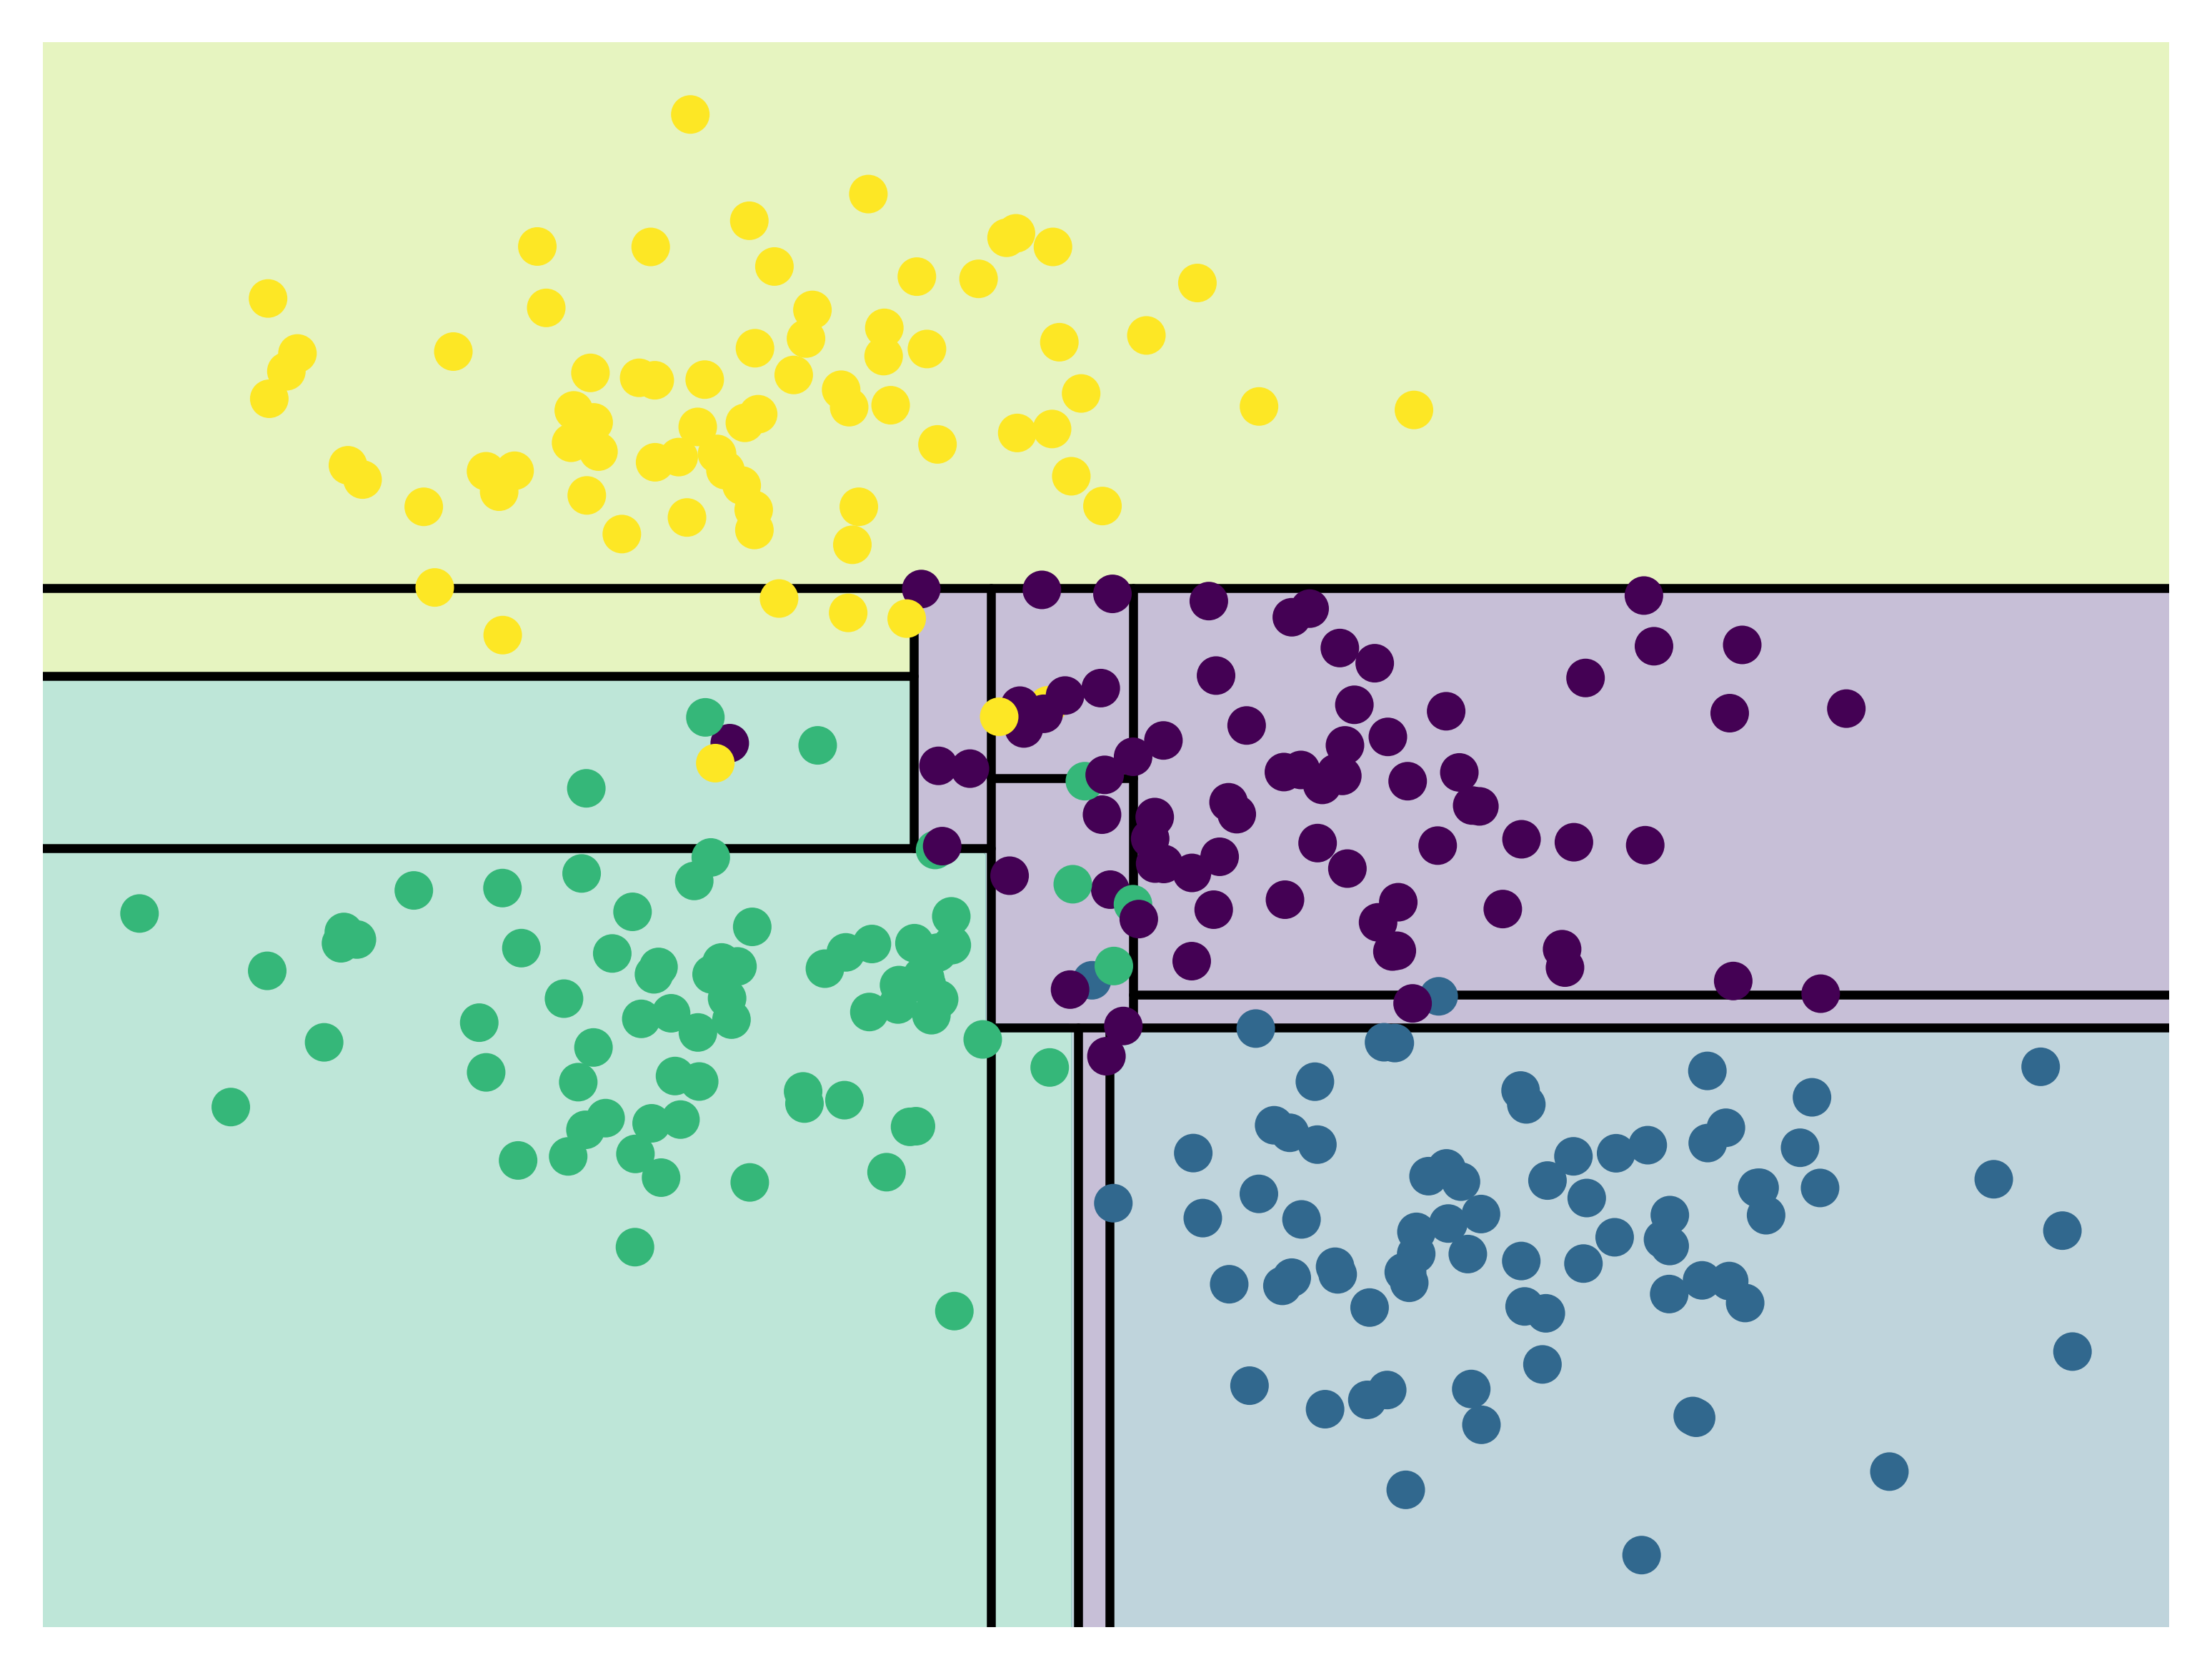

In [8]:

import helpers
helpers.plot_tree_interactive(X, y);

Observa que a medida que aumenta la profundidad, tendemos a obtener regiones de clasificación con formas muy extrañas; por ejemplo, en una profundidad de cinco, hay una región morada alta y delgada entre las regiones amarilla y azul.

Está claro que esto se debe menos a la verdadera distribución intrínseca de los datos, y más a las propiedades particulares de muestreo o ruido de los datos. Es decir, este árbol de decisión, incluso con solo cinco niveles de profundidad, está claramente sobreajustando (overfitting) nuestros datos.

### Árboles de decisión y sobreajuste

Este sobreajuste (*overfitting*) resulta ser una propiedad general de los árboles de decisión: es muy fácil profundizar demasiado en el árbol y, por lo tanto, ajustarse a los detalles de los datos particulares en lugar de a las propiedades generales de las distribuciones de las que provienen.

Otra forma de ver este sobreajuste es observar modelos entrenados con diferentes subconjuntos de los datos; por ejemplo, en esta figura entrenamos dos árboles diferentes, cada uno con la mitad de los datos originales.



![](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/images/05.08-decision-tree-overfitting.png?raw=1)
[figure source in Appendix](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/06.00-Figure-Code.ipynb#Decision-Tree-Overfitting)

Es evidente que en algunos lugares los dos árboles producen resultados consistentes (por ejemplo, en las cuatro esquinas), mientras que en otros lugares los dos árboles dan clasificaciones muy diferentes (por ejemplo, en las regiones entre dos grupos cualesquiera).

La observación clave es que las inconsistencias tienden a ocurrir donde la clasificación es menos certera, y por lo tanto, al utilizar la información de *ambos* árboles, ¡podríamos obtener un mejor resultado!

Si estás ejecutando este notebook en vivo, la siguiente función te permitirá visualizar de forma interactiva los ajustes de los árboles entrenados con un subconjunto aleatorio de los datos:

interactive(children=(IntSlider(value=0, description='random_state'), Output()), _dom_classes=('widget-interac…

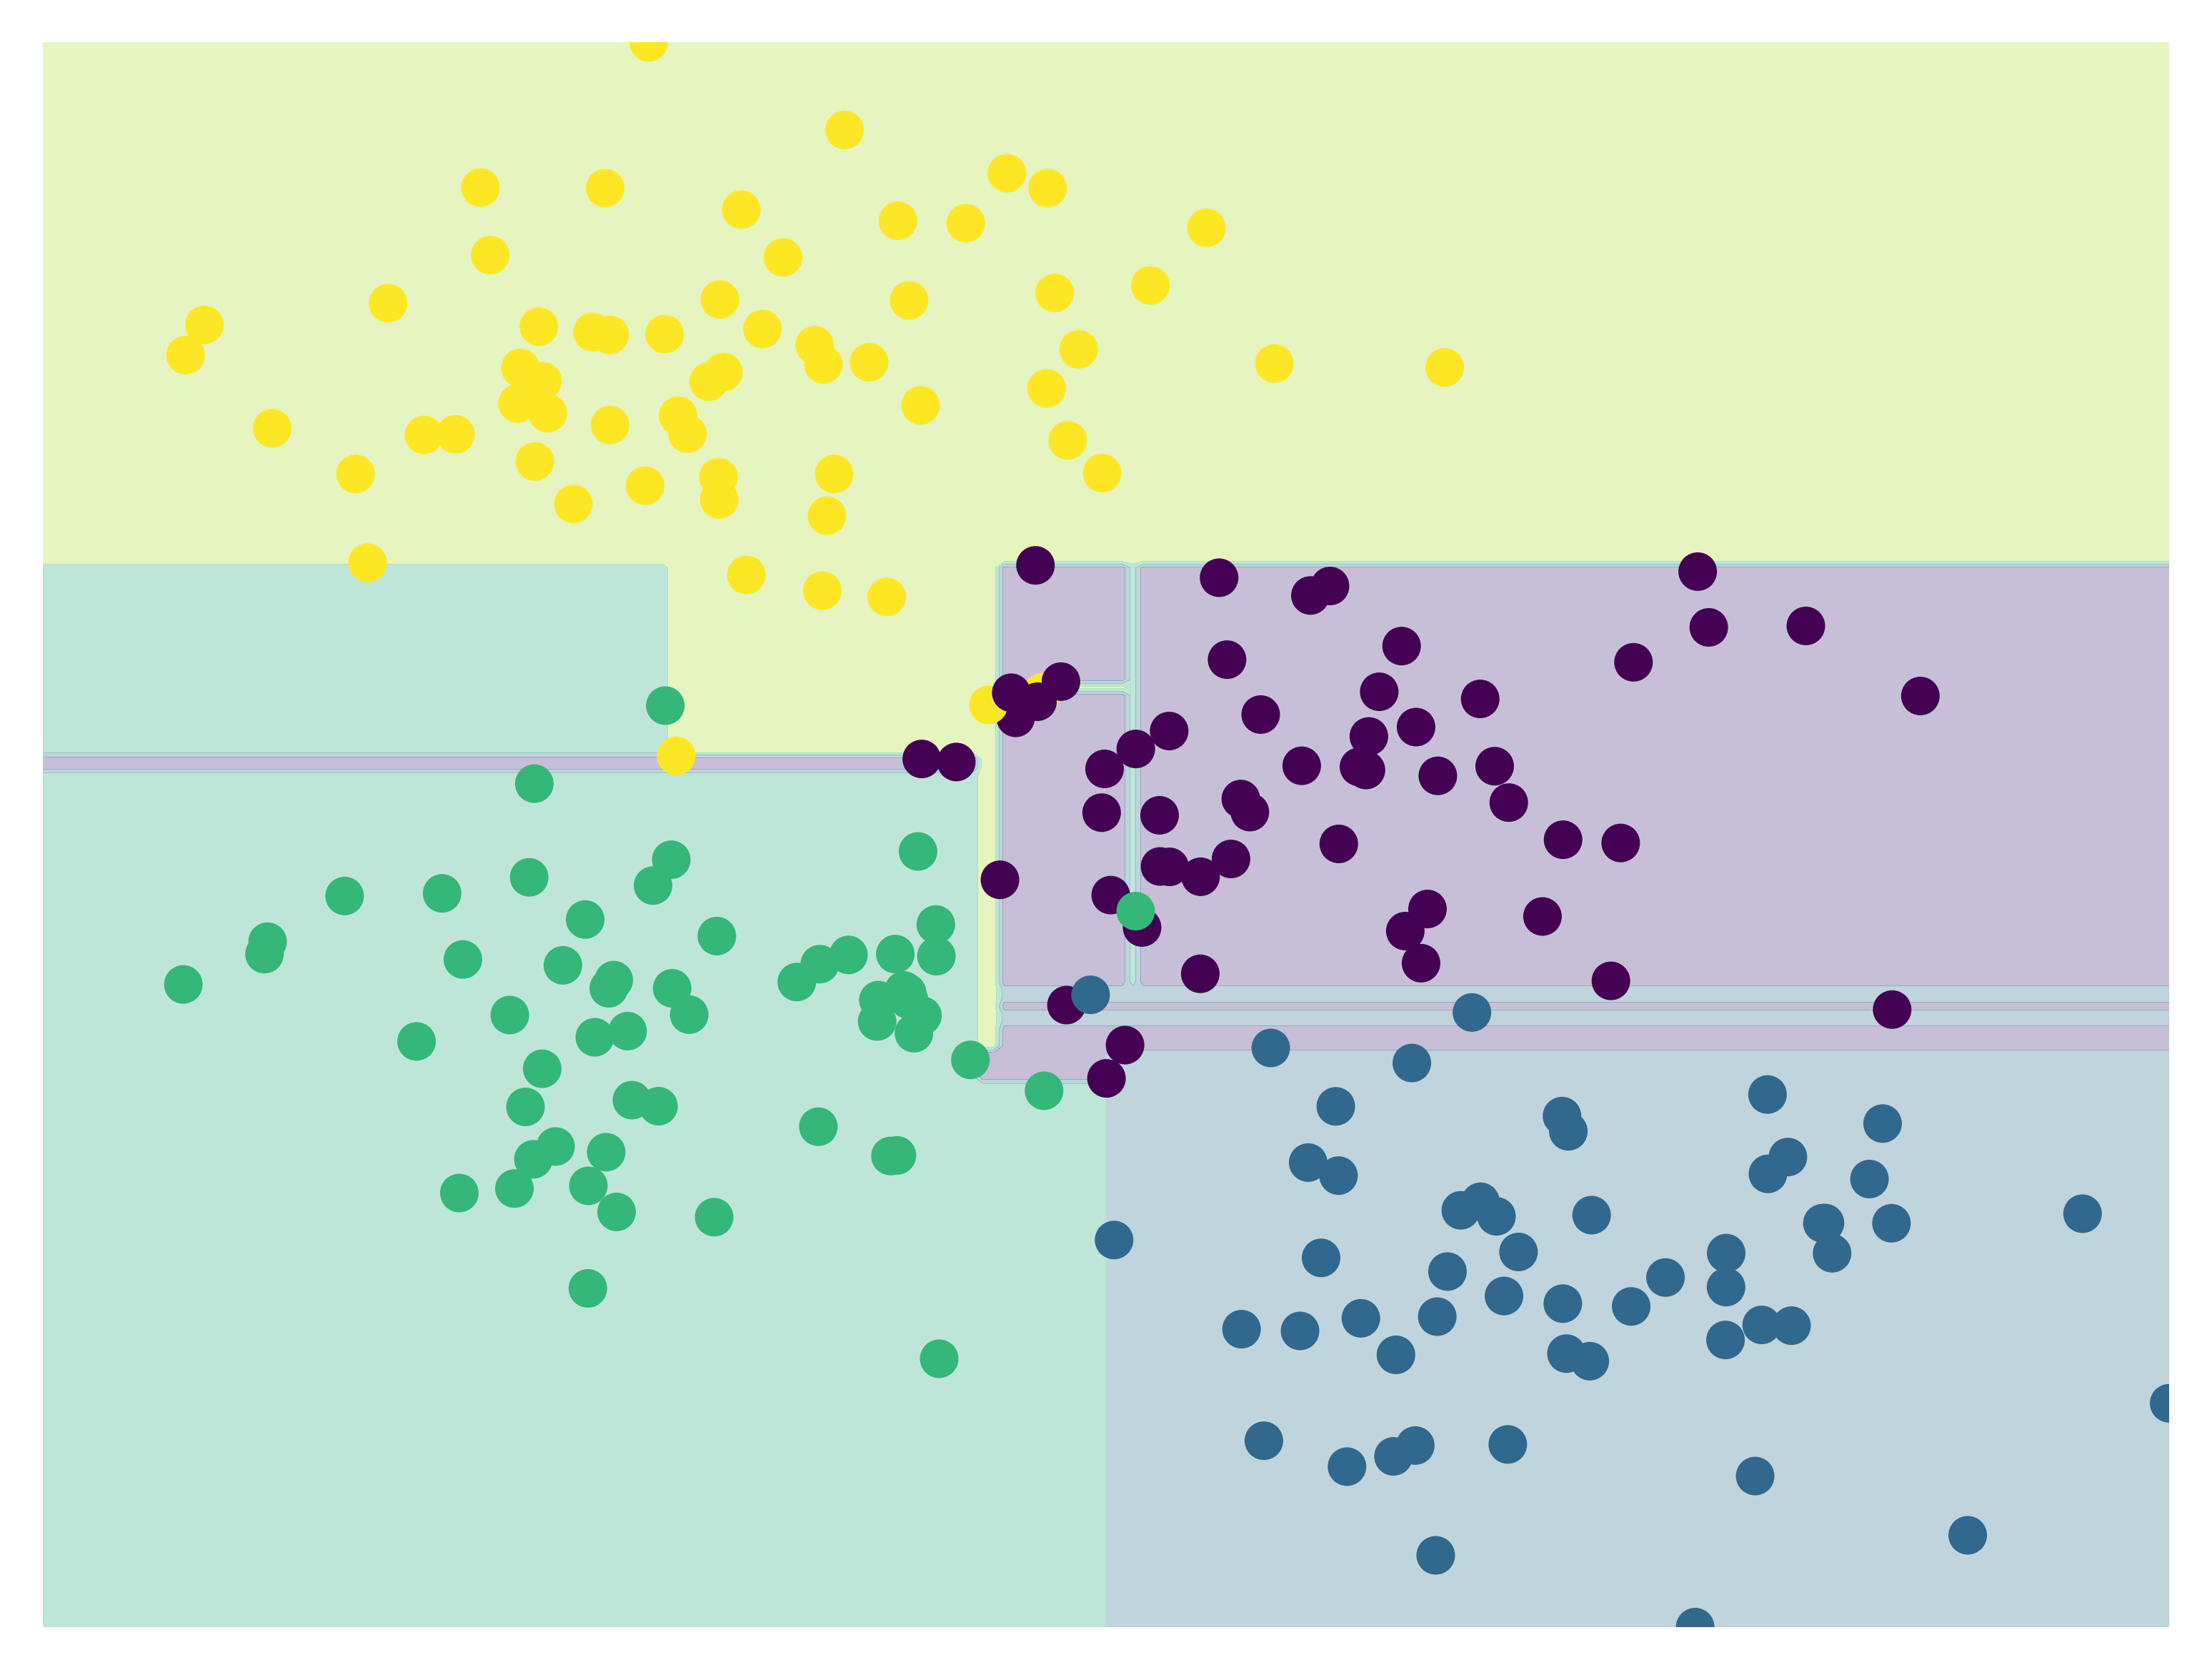

In [9]:
# helpers_05_08 is found in the online appendix
import helpers
helpers.randomized_tree_interactive(X, y)

Tal como el uso de información de dos árboles mejora nuestros resultados, podríamos esperar que el uso de información de muchos árboles mejore nuestros resultados aún más.

## Ensambles de estimadores: Bosques aleatorios

Esta noción —que múltiples estimadores sobreajustados pueden combinarse para reducir el efecto de este sobreajuste— es lo que subyace en un método de ensamble llamado *bagging* (agregación por *bootstrap*).
El *bagging* hace uso de un ensamble (una bolsa mixta, quizás) de estimadores paralelos, cada uno de los cuales sobreajusta los datos, y promedia los resultados para encontrar una mejor clasificación.
Un ensamble de árboles de decisión aleatorizados se conoce como *bosque aleatorio* (random forest).

Este tipo de clasificación *bagging* se puede realizar manualmente utilizando el meta-estimador `BaggingClassifier` de Scikit-Learn, como se muestra aquí (ver la siguiente figura):

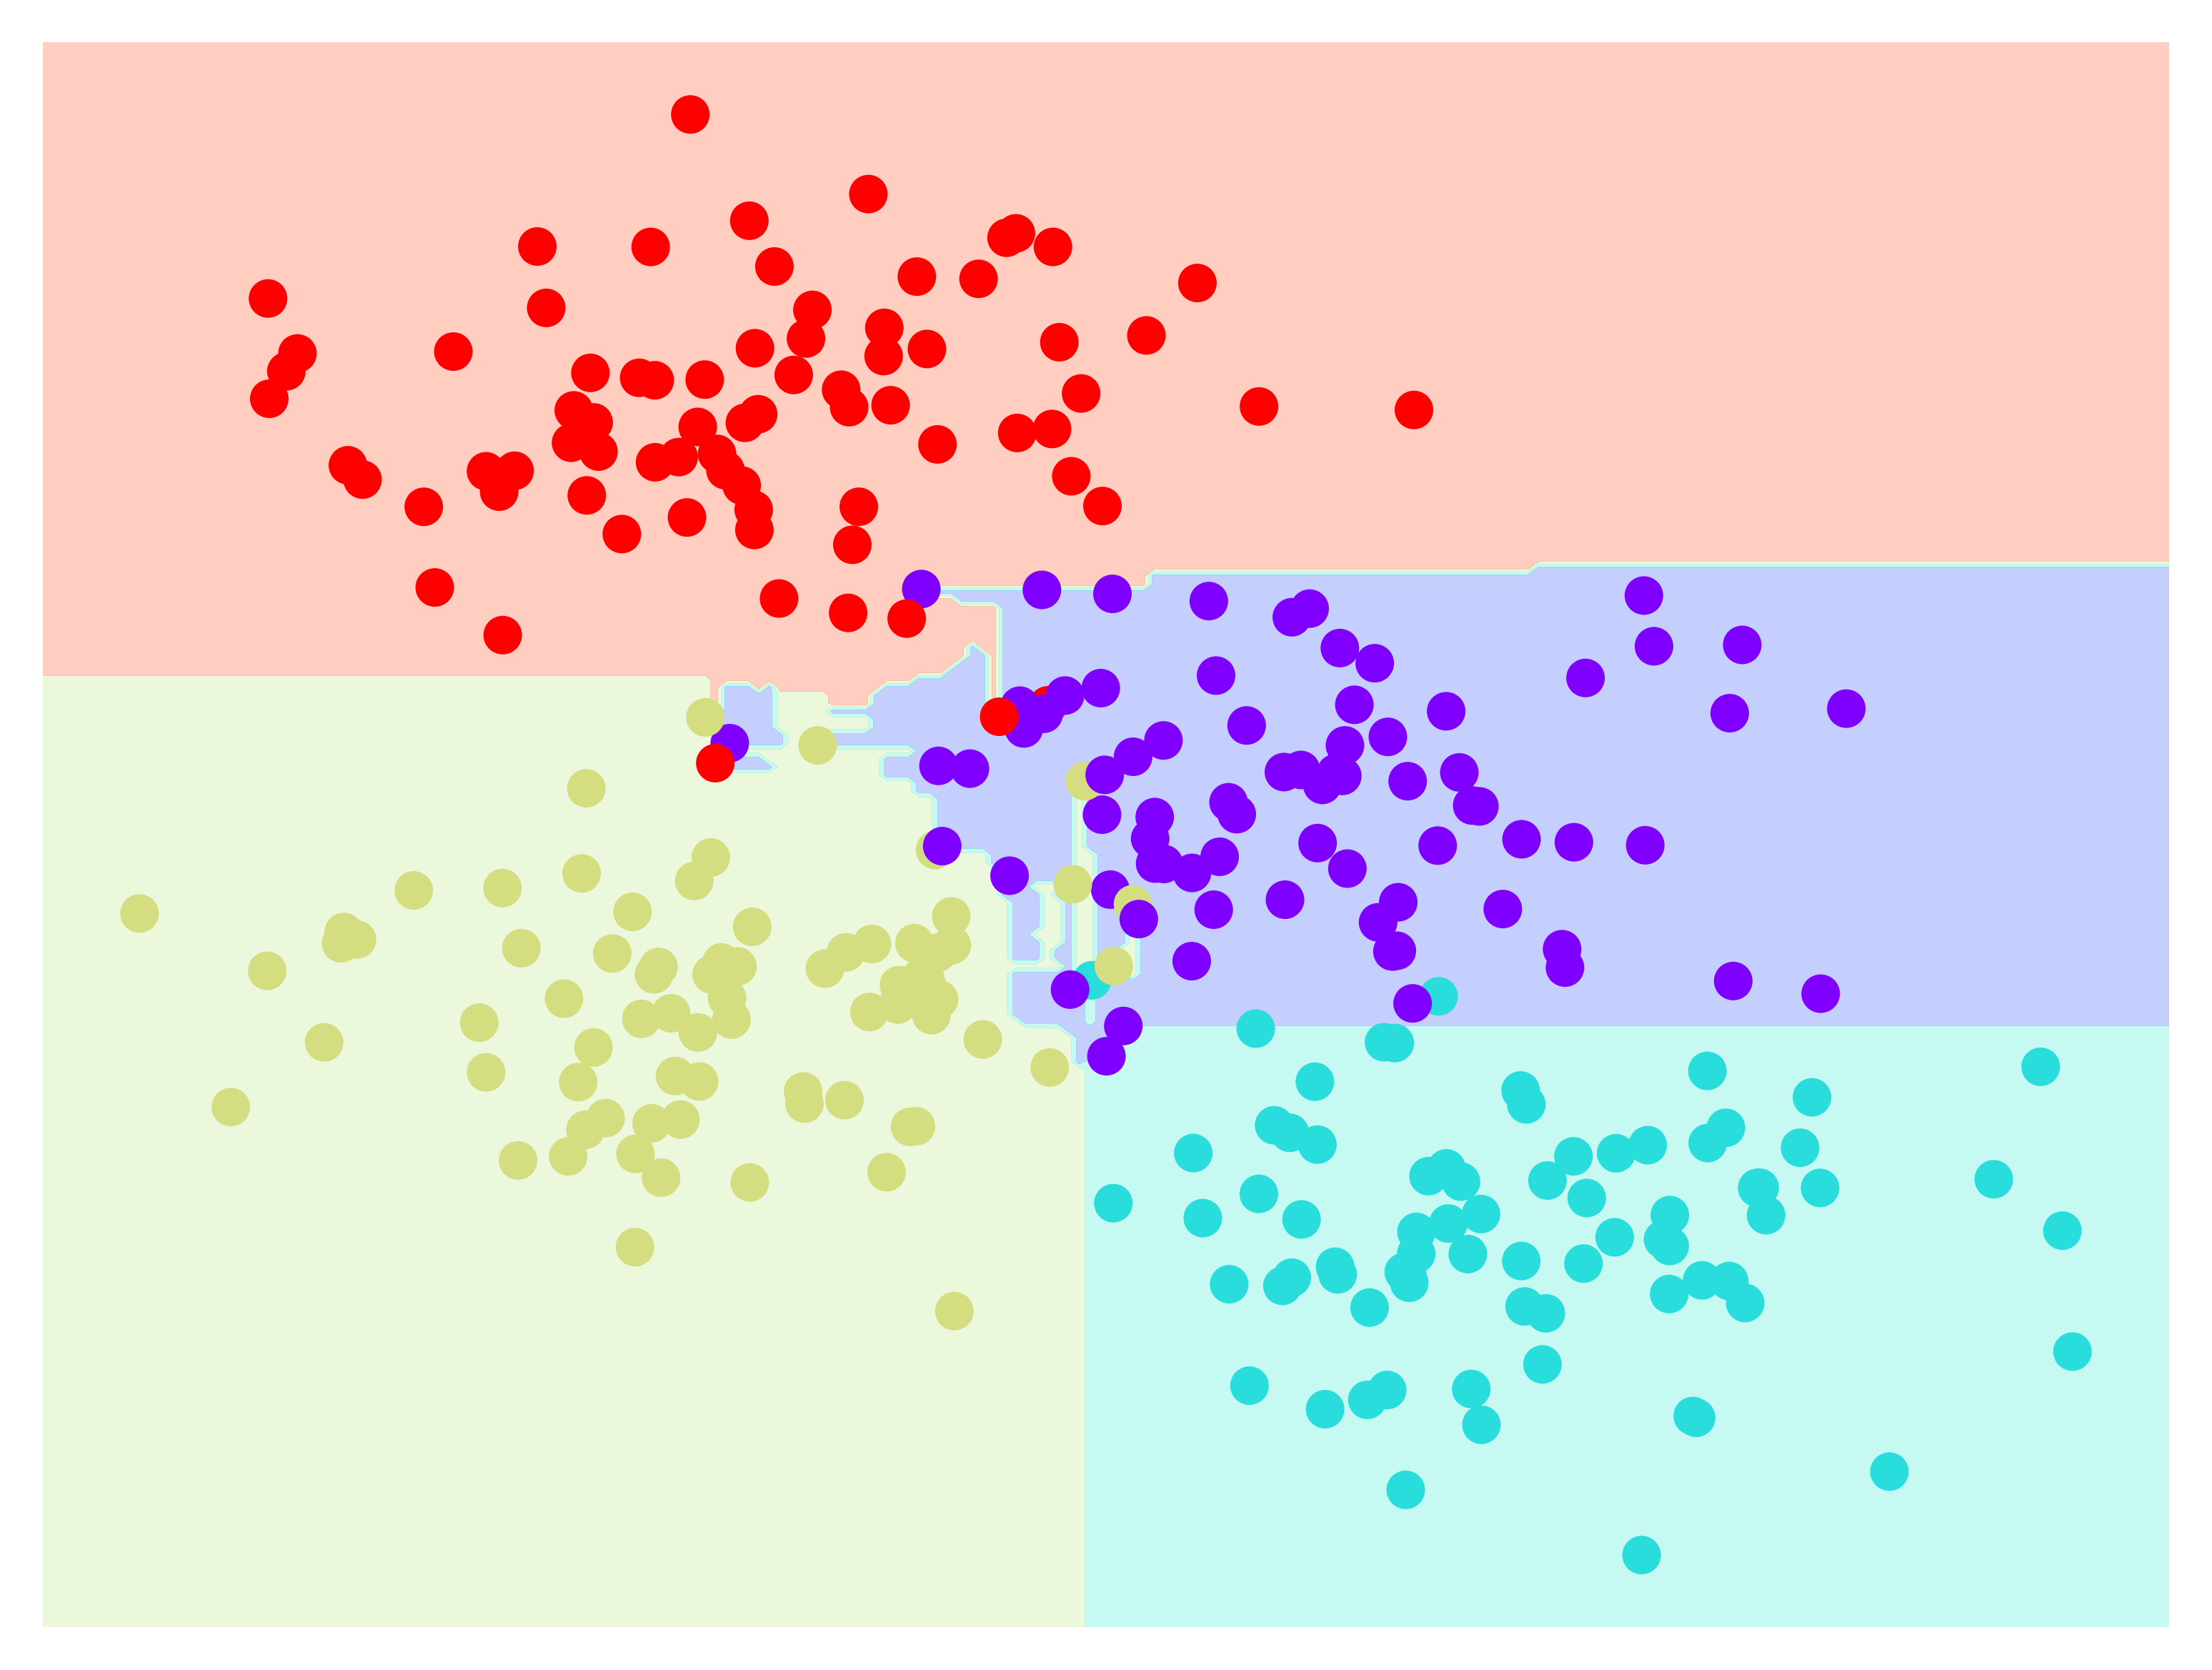

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier()
bag = BaggingClassifier(tree, n_estimators=100, max_samples=0.8,
                        random_state=1)

bag.fit(X, y)
visualize_classifier(bag, X, y)

En este ejemplo, hemos aleatorizado los datos ajustando cada estimador con un subconjunto aleatorio del 80% de los puntos de entrenamiento.
En la práctica, los árboles de decisión se aleatorizan de manera más efectiva introduciendo cierta estocasticidad en la forma en que se eligen las divisiones: de esta manera, todos los datos contribuyen al ajuste cada vez, pero los resultados del ajuste siguen teniendo la aleatoriedad deseada.
Por ejemplo, al determinar sobre qué característica realizar la división, el árbol aleatorizado podría seleccionar entre las mejores características.
Puedes leer más detalles técnicos sobre estas estrategias de aleatorización en la [documentación de Scikit-Learn](http://scikit-learn.org/stable/modules/ensemble.html#forest) y en las referencias que allí se encuentran.

En Scikit-Learn, un ensamble optimizado de árboles de decisión aleatorizados de este tipo se implementa en el estimador `RandomForestClassifier`, que se encarga de toda la aleatorización automáticamente.
Todo lo que necesitas hacer es seleccionar una cantidad de estimadores, y este ajustará muy rápidamente —en paralelo, si se desea— el ensamble de árboles (ver la siguiente figura):

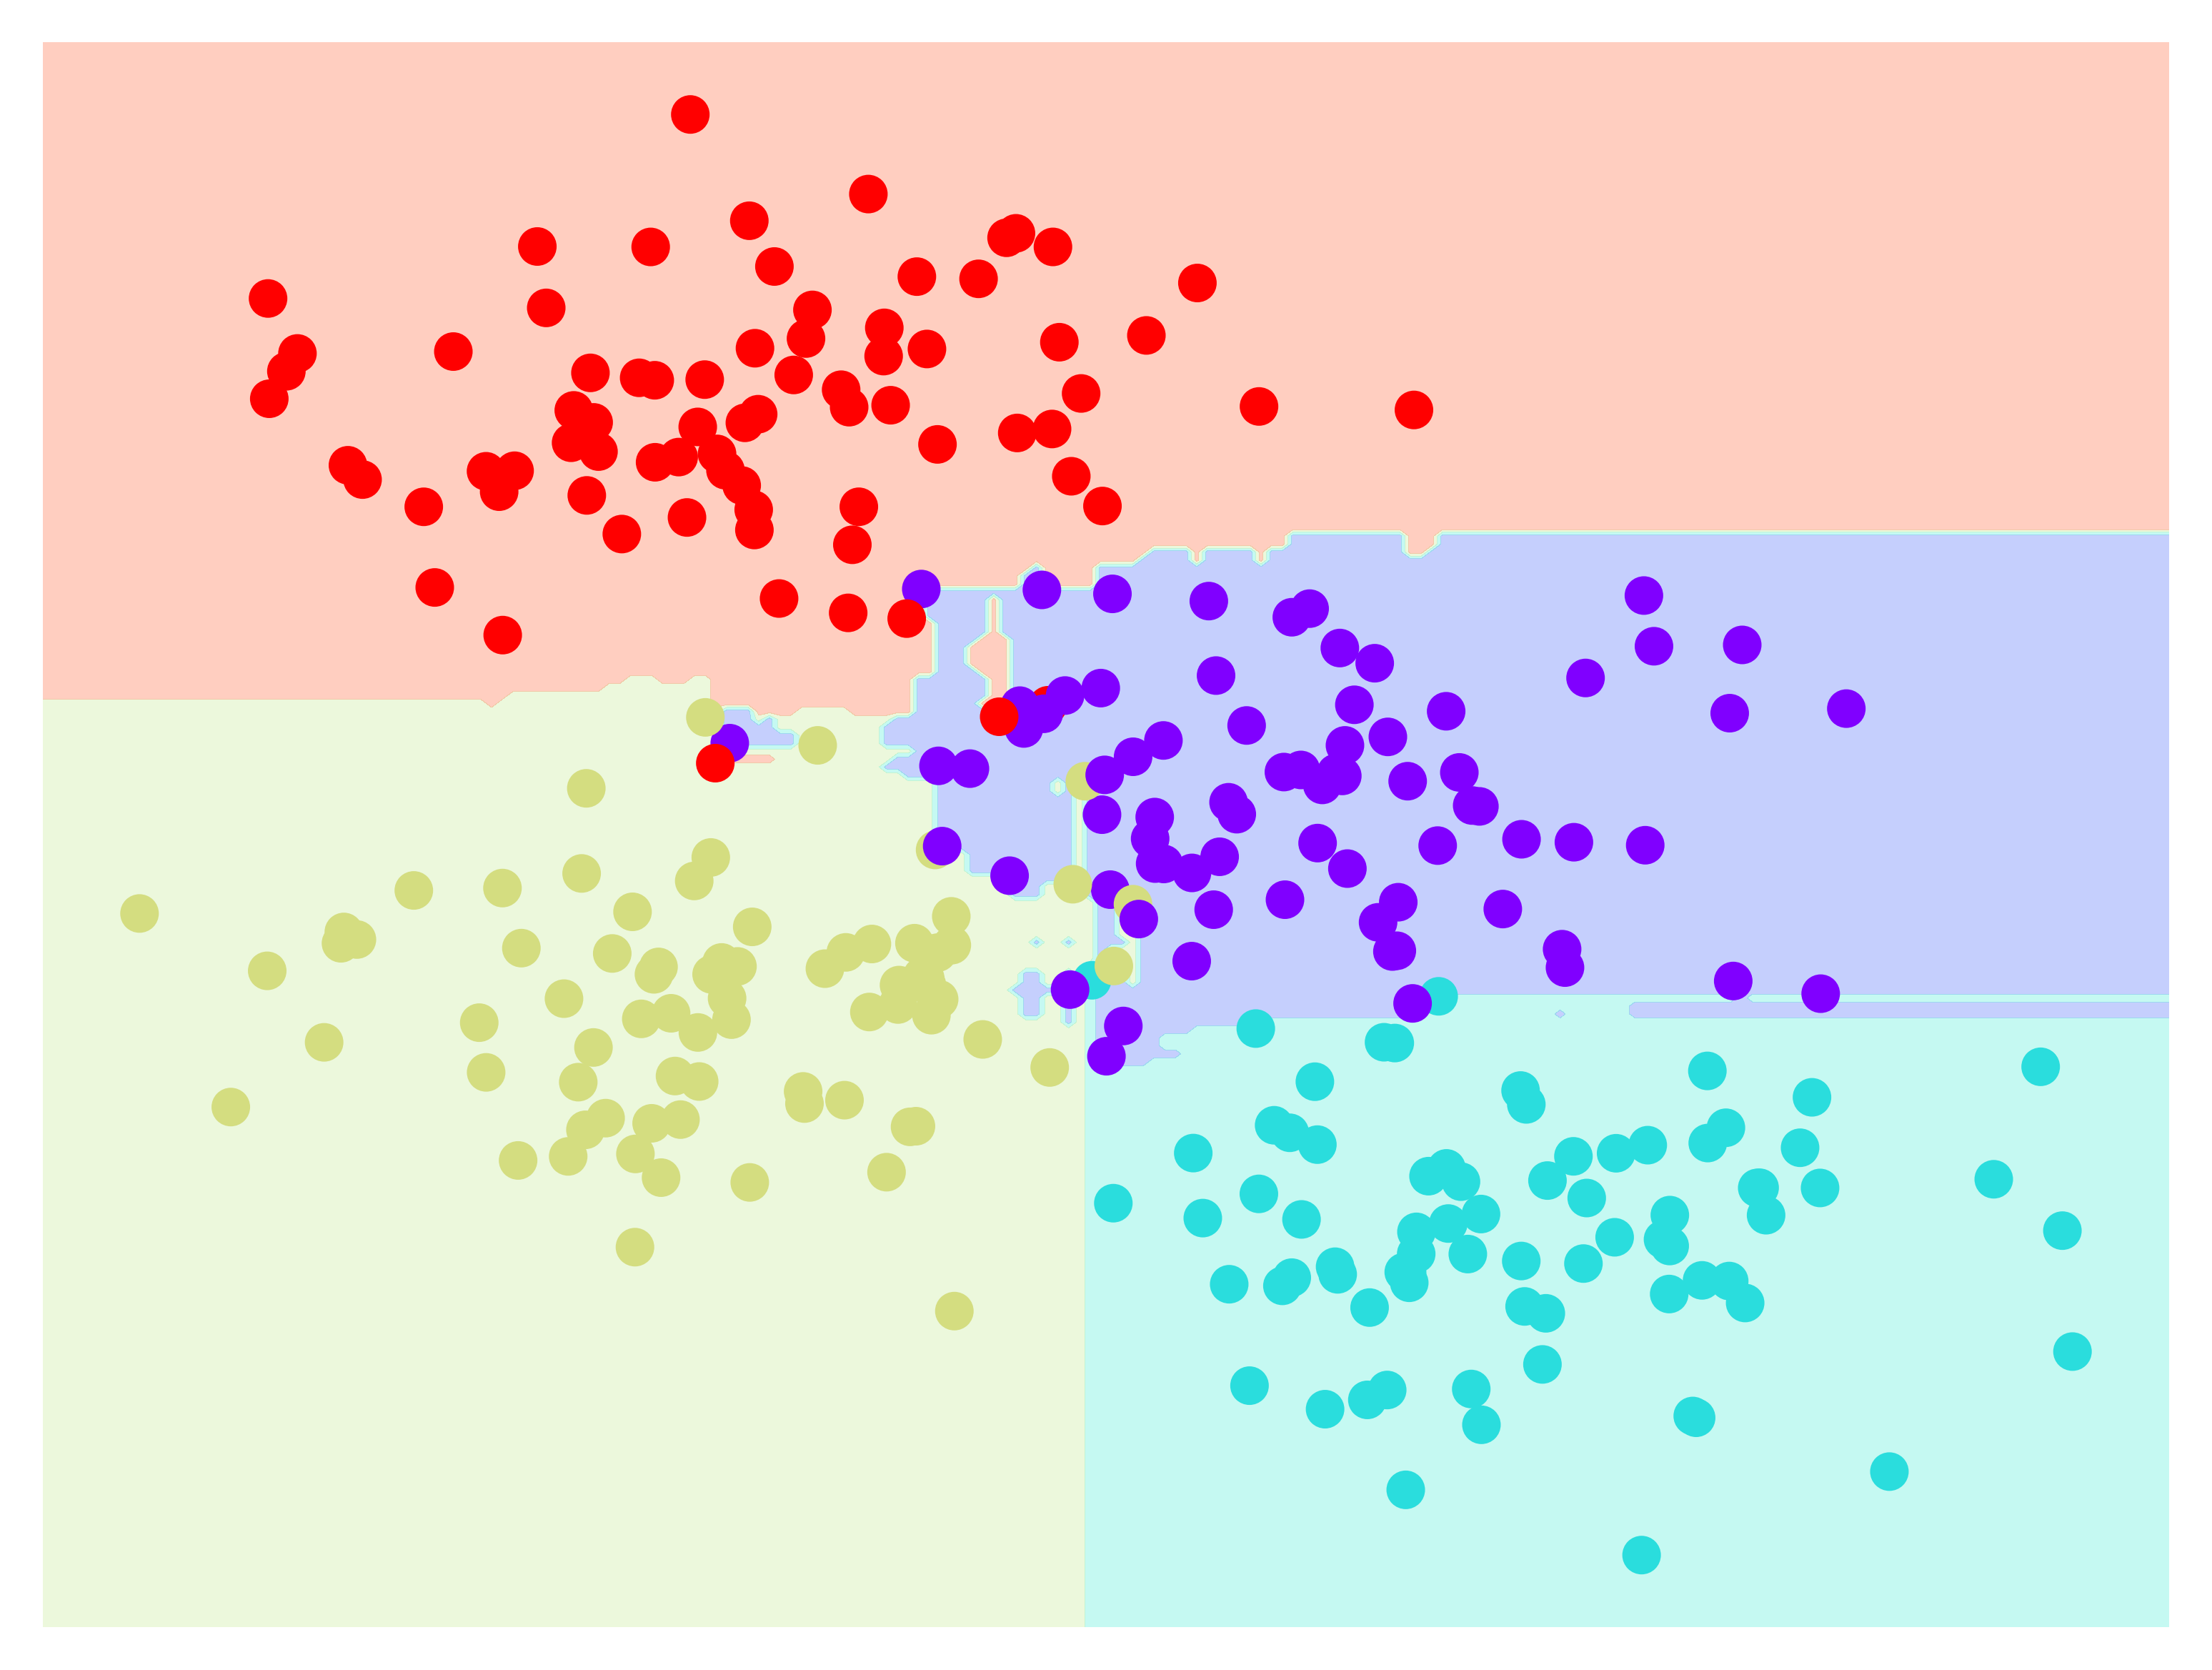

In [11]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=0)
visualize_classifier(model, X, y);

Vemos que al promediar 100 modelos perturbados aleatoriamente, obtenemos un modelo general que se acerca mucho más a nuestra intuición sobre cómo debería dividirse el espacio de parámetros.

## Regresión con bosques aleatorios

En la sección anterior consideramos los bosques aleatorios dentro del contexto de la clasificación.
Los bosques aleatorios también pueden funcionar en el caso de la regresión (es decir, con variables continuas en lugar de categóricas). El estimador a utilizar para esto es el `RandomForestRegressor`, y la sintaxis es muy similar a la que vimos anteriormente.

Considera los siguientes datos, extraídos de la combinación de una oscilación rápida y una lenta (ver la siguiente figura):



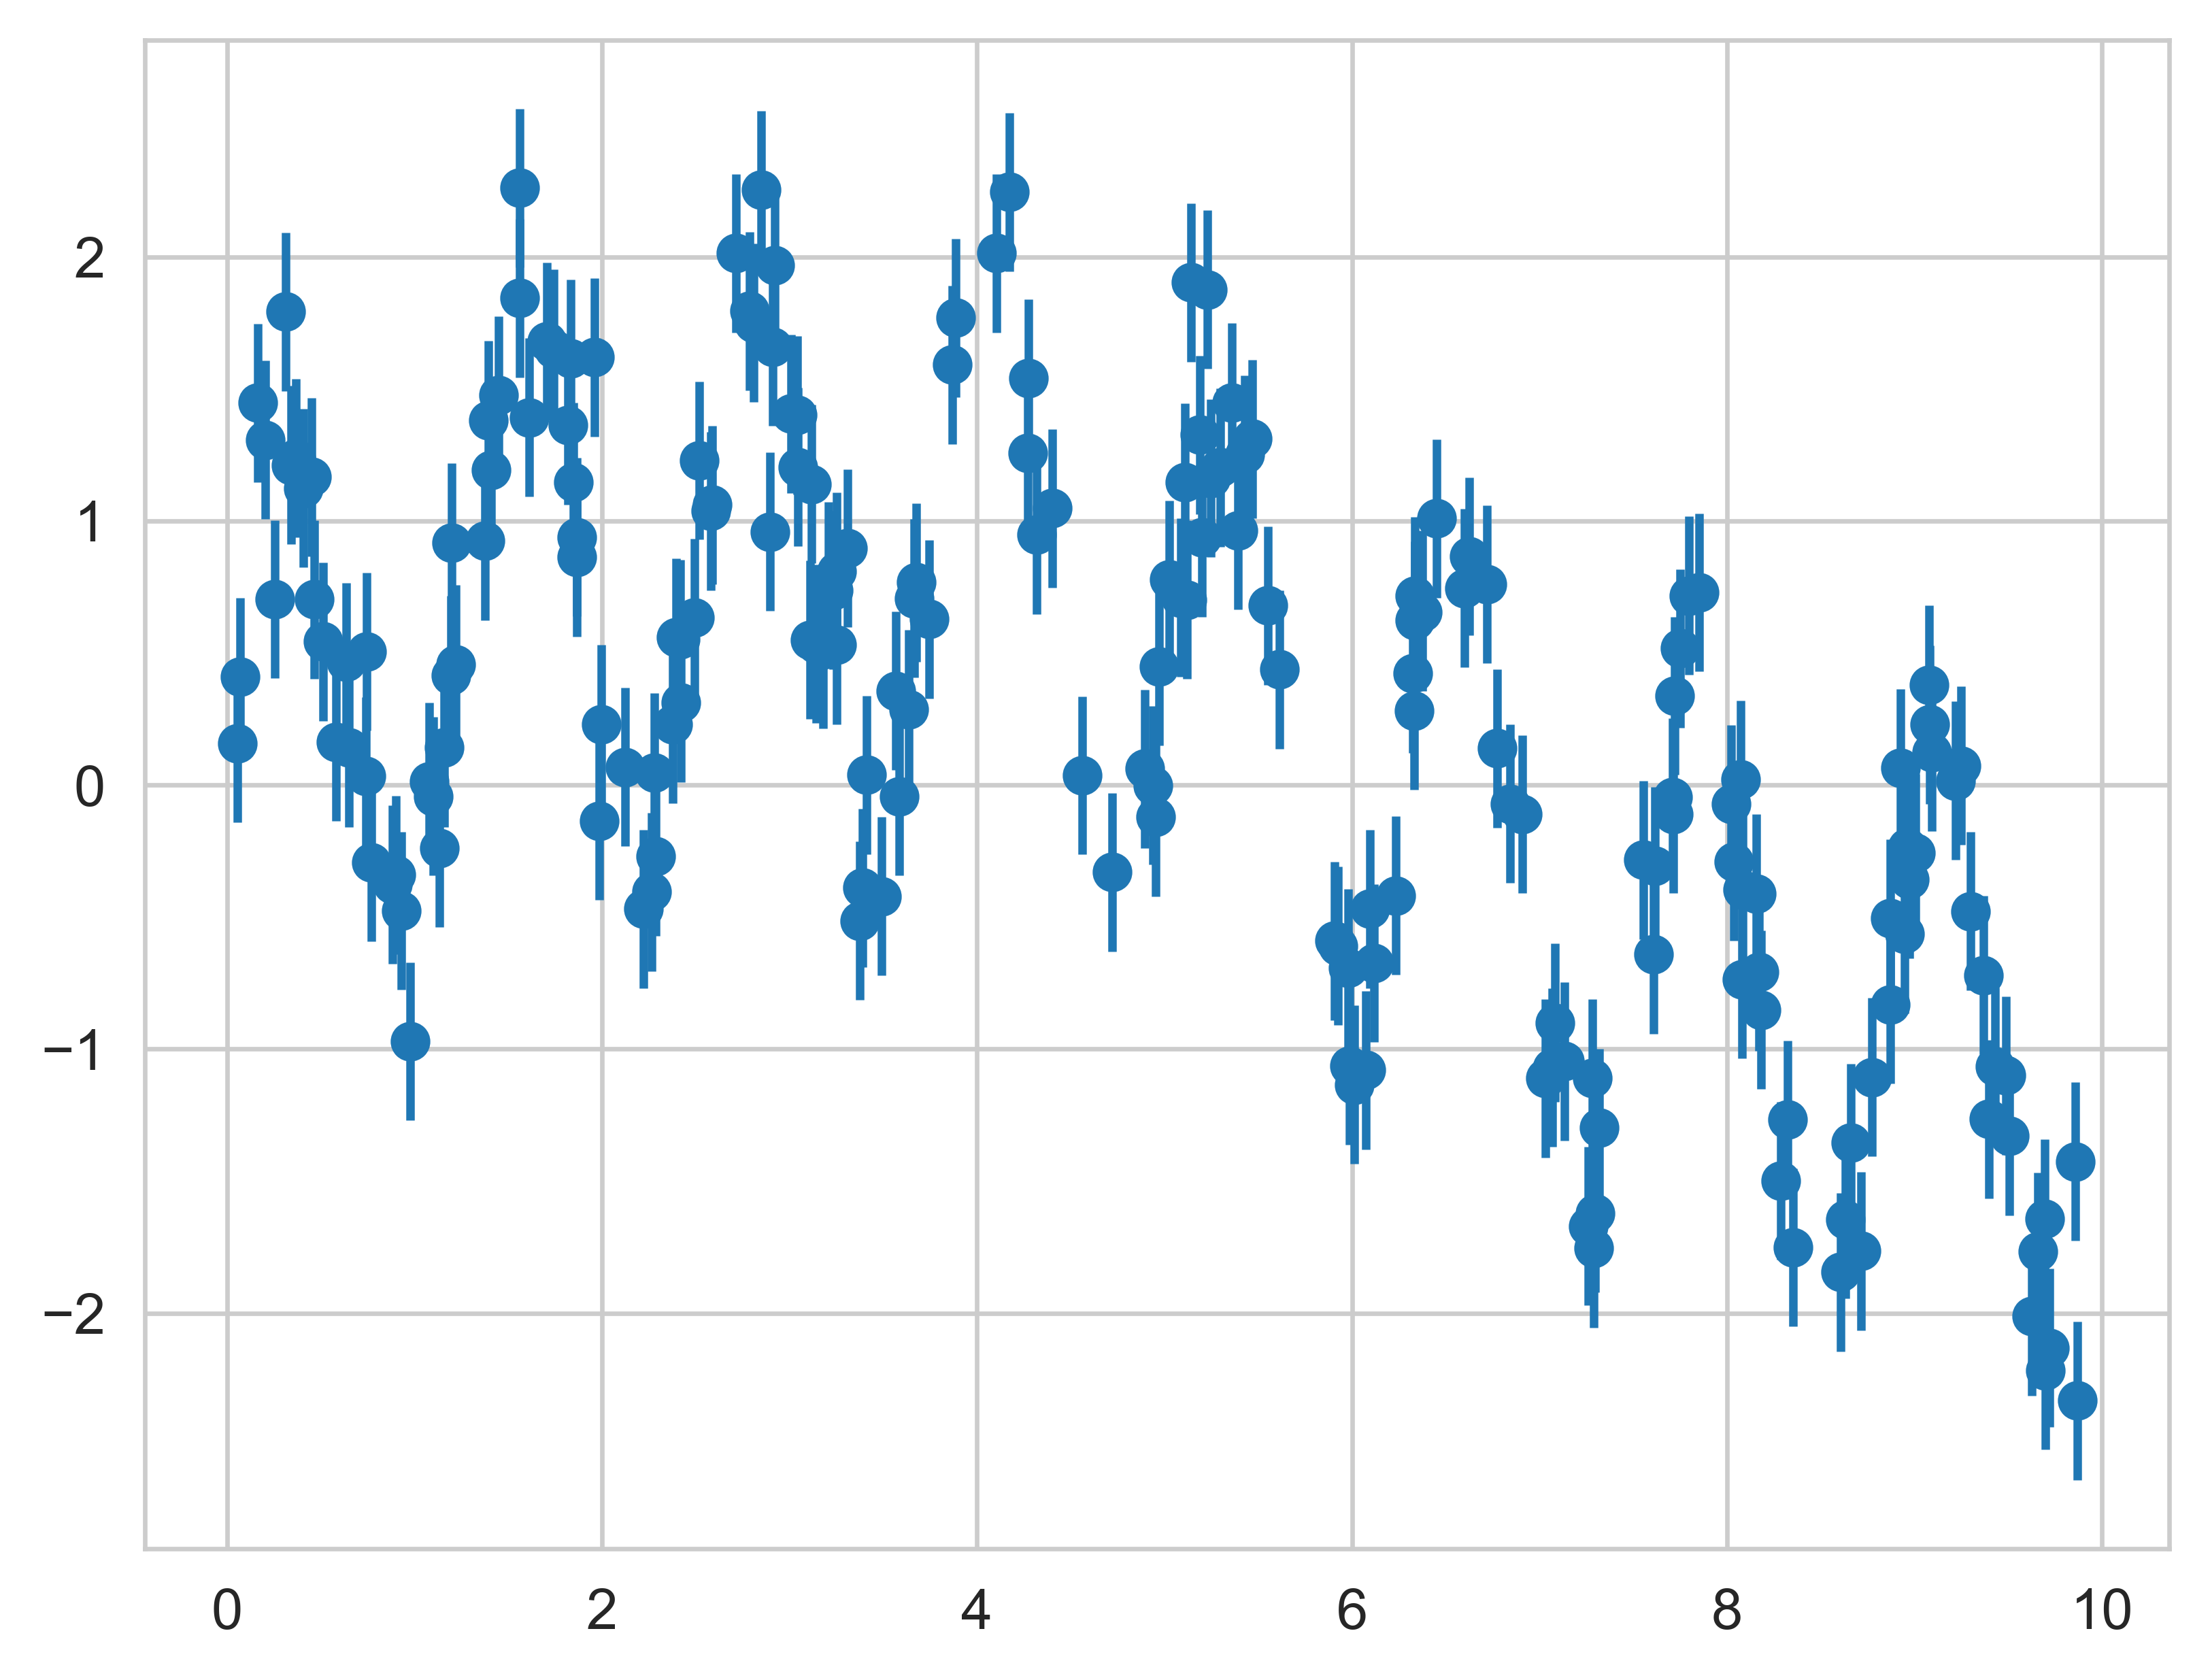

In [12]:
rng = np.random.RandomState(42)
x = 10 * rng.rand(200)

def model(x, sigma=0.3):
    fast_oscillation = np.sin(5 * x)
    slow_oscillation = np.sin(0.5 * x)
    noise = sigma * rng.randn(len(x))

    return slow_oscillation + fast_oscillation + noise

y = model(x)
plt.errorbar(x, y, 0.3, fmt='o');

Utilizando el regresor de bosque aleatorio, podemos encontrar la curva de mejor ajuste de la siguiente manera (ver la siguiente figura):

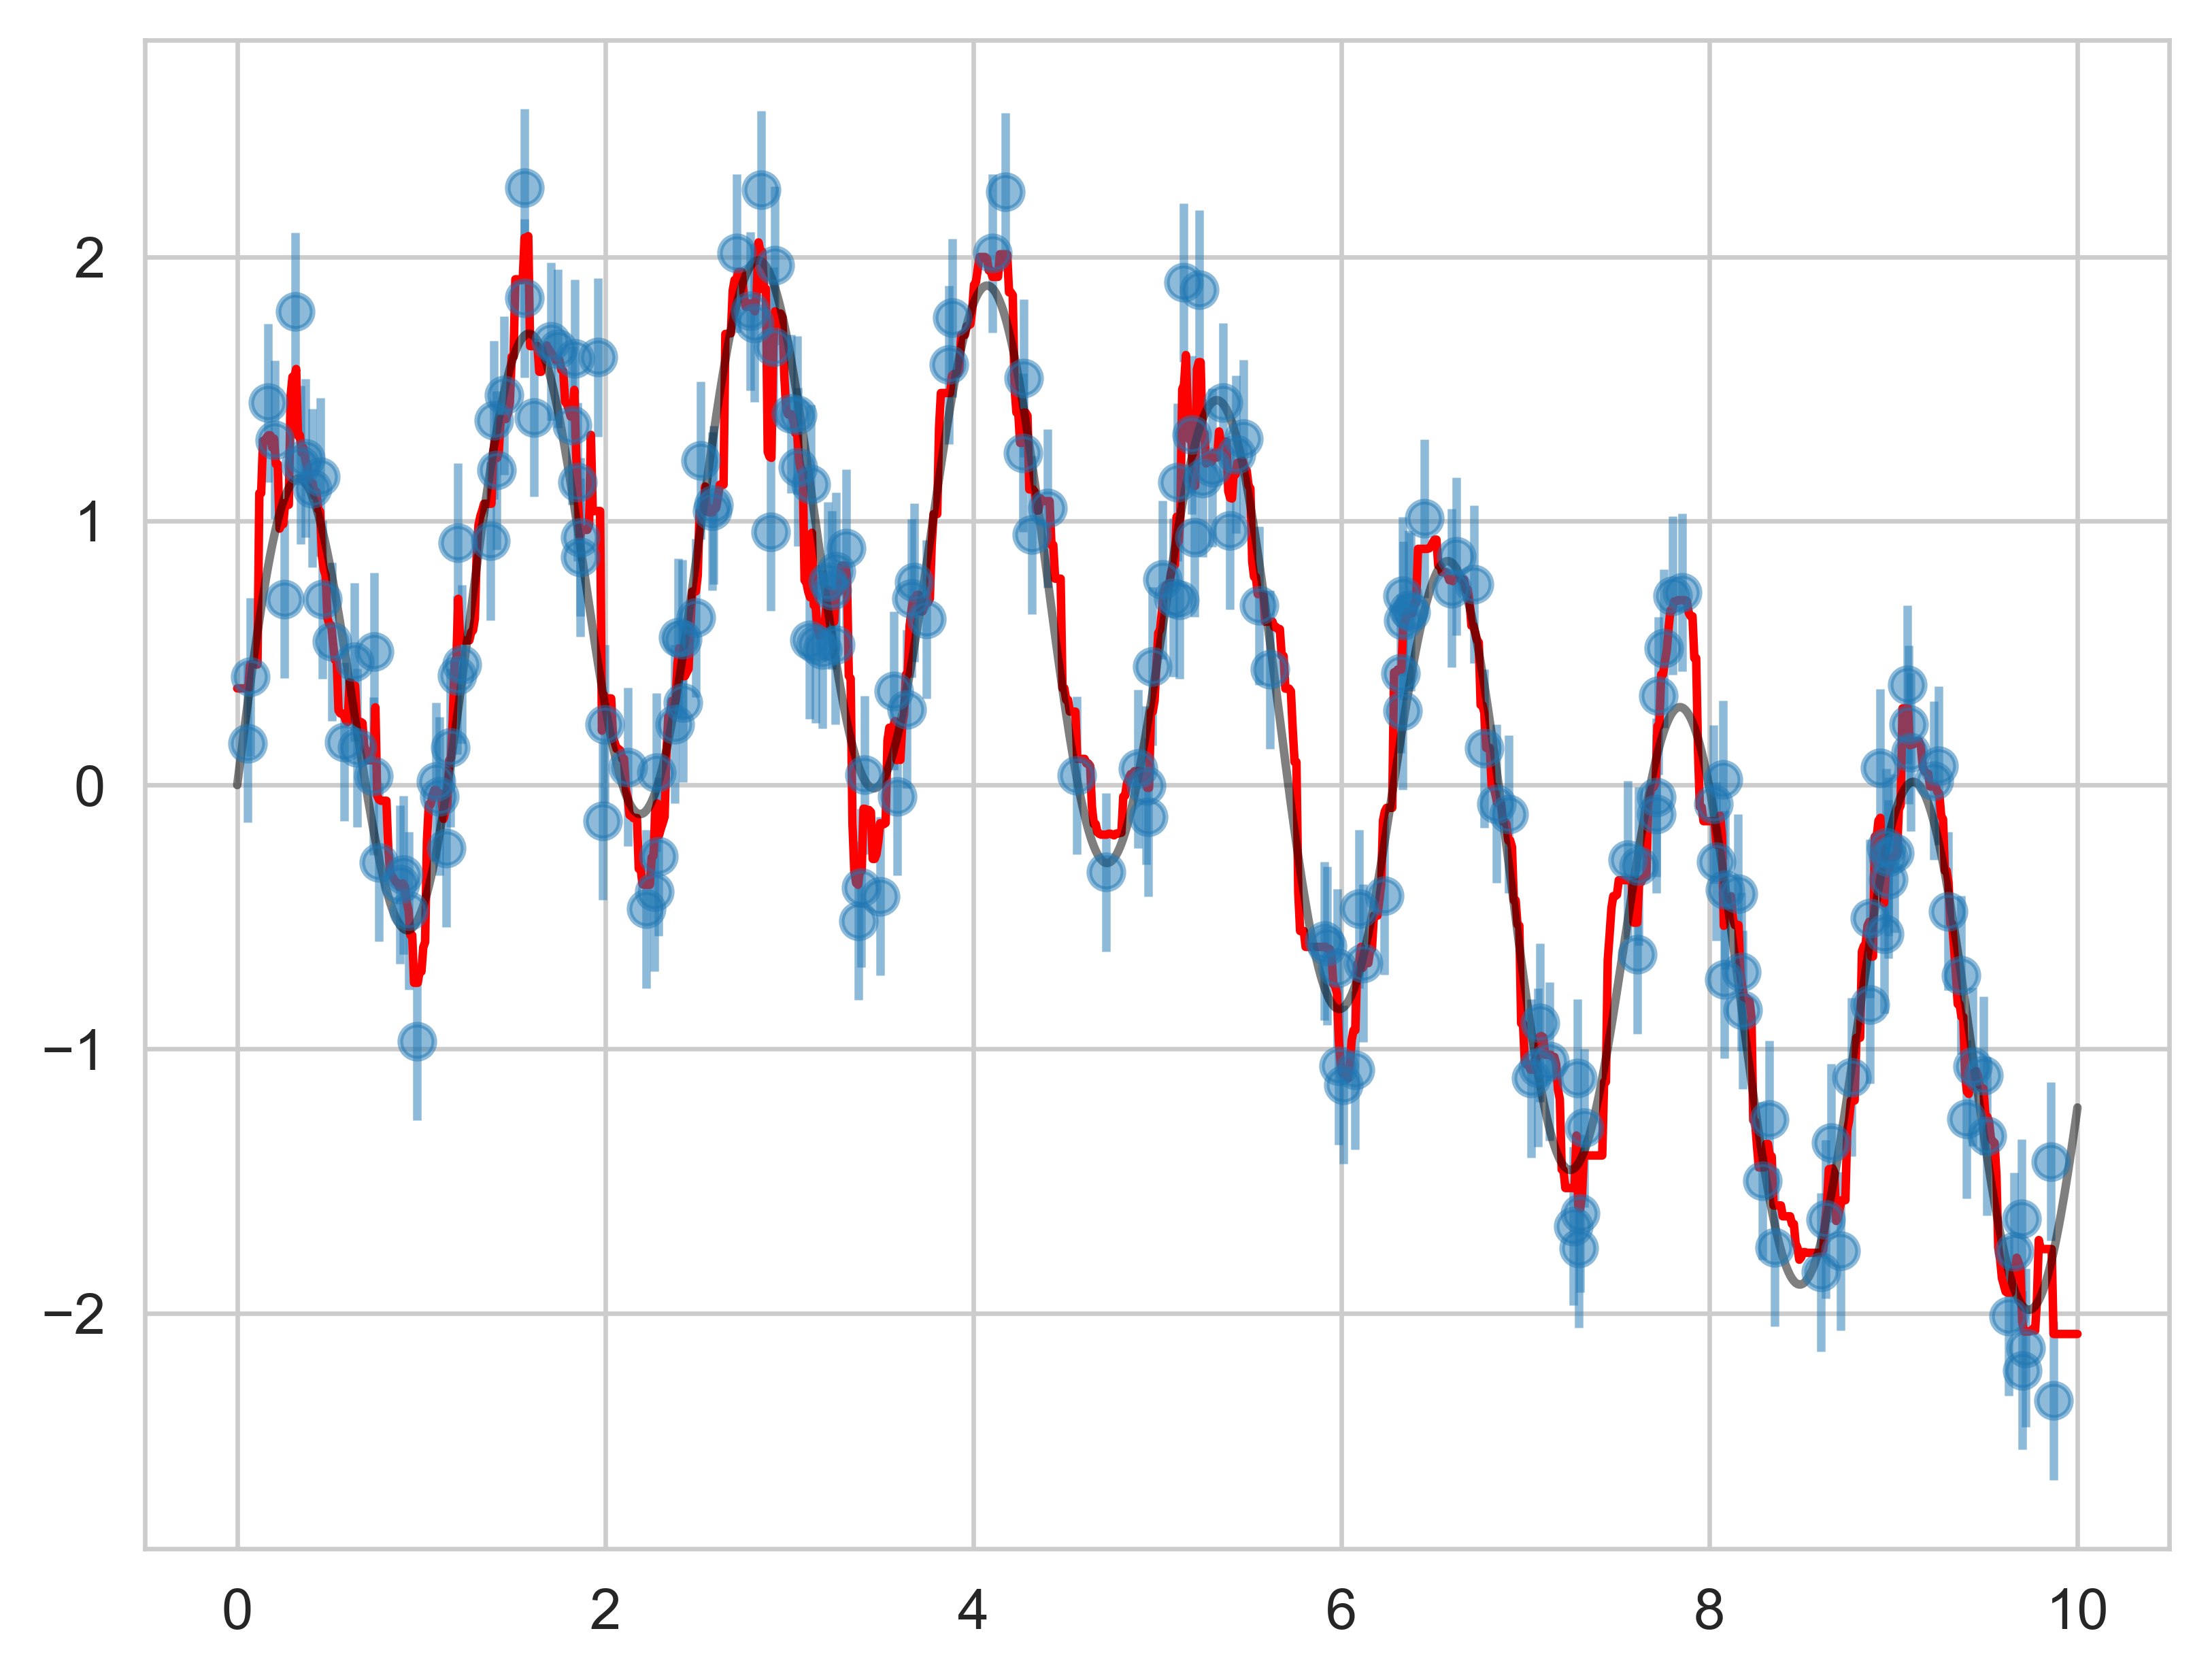

In [13]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(200)
forest.fit(x[:, None], y)

xfit = np.linspace(0, 10, 1000)
yfit = forest.predict(xfit[:, None])
ytrue = model(xfit, sigma=0)

plt.errorbar(x, y, 0.3, fmt='o', alpha=0.5)
plt.plot(xfit, yfit, '-r');
plt.plot(xfit, ytrue, '-k', alpha=0.5);

Aquí, el modelo verdadero se muestra en la curva gris suave, mientras que el modelo de bosque aleatorio se muestra mediante la curva roja irregular. ¡El modelo de bosque aleatorio no paramétrico es lo suficientemente flexible como para ajustarse a los datos multiperíodo, sin necesidad de especificar un modelo multiperíodo!

## Ejemplo: Bosque aleatorio para clasificar dígitos

En el Capítulo 38 trabajamos con un ejemplo utilizando el conjunto de datos de dígitos incluido en Scikit-Learn.
Usémoslo de nuevo aquí para ver cómo se puede aplicar el clasificador de bosque aleatorio en este contexto:

In [14]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

Para recordarnos lo que estamos viendo, visualizaremos los primeros puntos de datos (ver la siguiente figura):



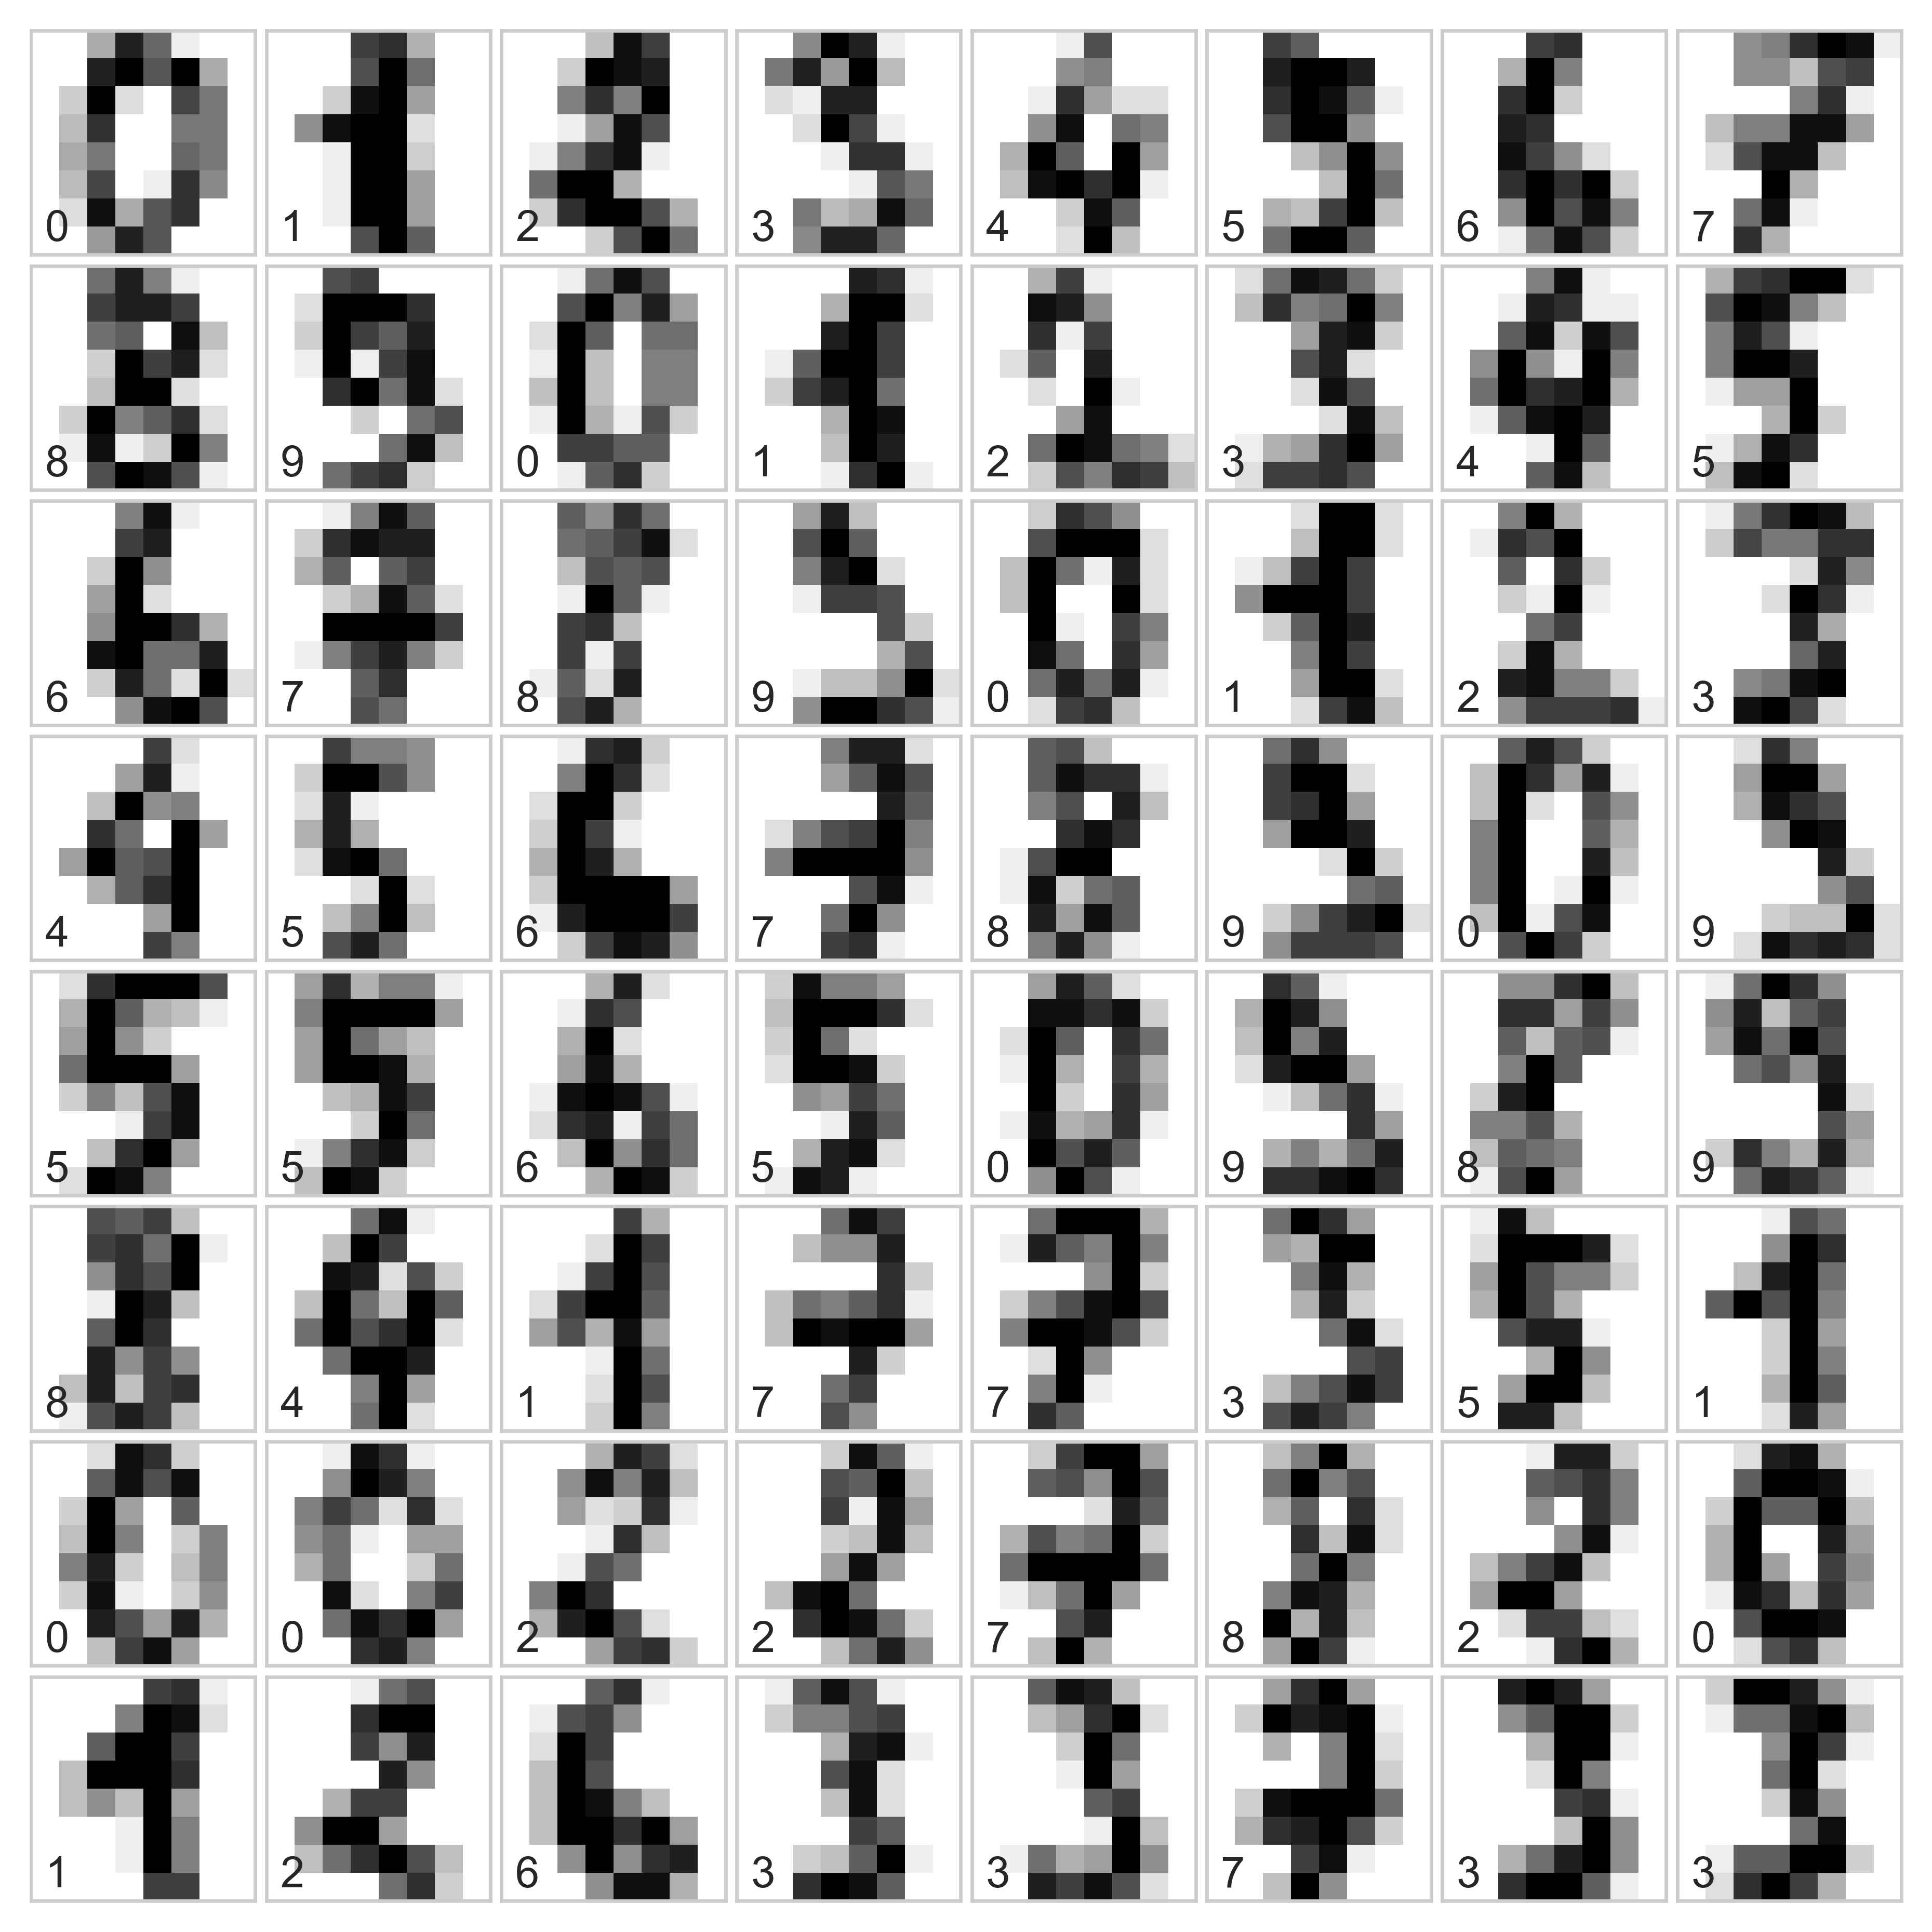

In [15]:
# set up the figure
fig = plt.figure(figsize=(6, 6))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# plot the digits: each image is 8x8 pixels
for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(digits.images[i], cmap=plt.cm.binary, interpolation='nearest')

    # label the image with the target value
    ax.text(0, 7, str(digits.target[i]))

Podemos clasificar los dígitos utilizando un bosque aleatorio de la siguiente manera:

In [16]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(digits.data, digits.target,
                                                random_state=0)
model = RandomForestClassifier(n_estimators=1000)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)

Veamos el informe de clasificación de este clasificador:

In [17]:
from sklearn import metrics
print(metrics.classification_report(ypred, ytest))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99        38
           1       0.98      0.95      0.97        44
           2       0.95      1.00      0.98        42
           3       0.98      0.98      0.98        45
           4       0.97      1.00      0.99        37
           5       0.98      0.96      0.97        49
           6       1.00      1.00      1.00        52
           7       1.00      0.96      0.98        50
           8       0.94      0.98      0.96        46
           9       0.98      0.98      0.98        47

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450



Y como medida adicional, grafiquemos la matriz de confusión (ver la siguiente figura):

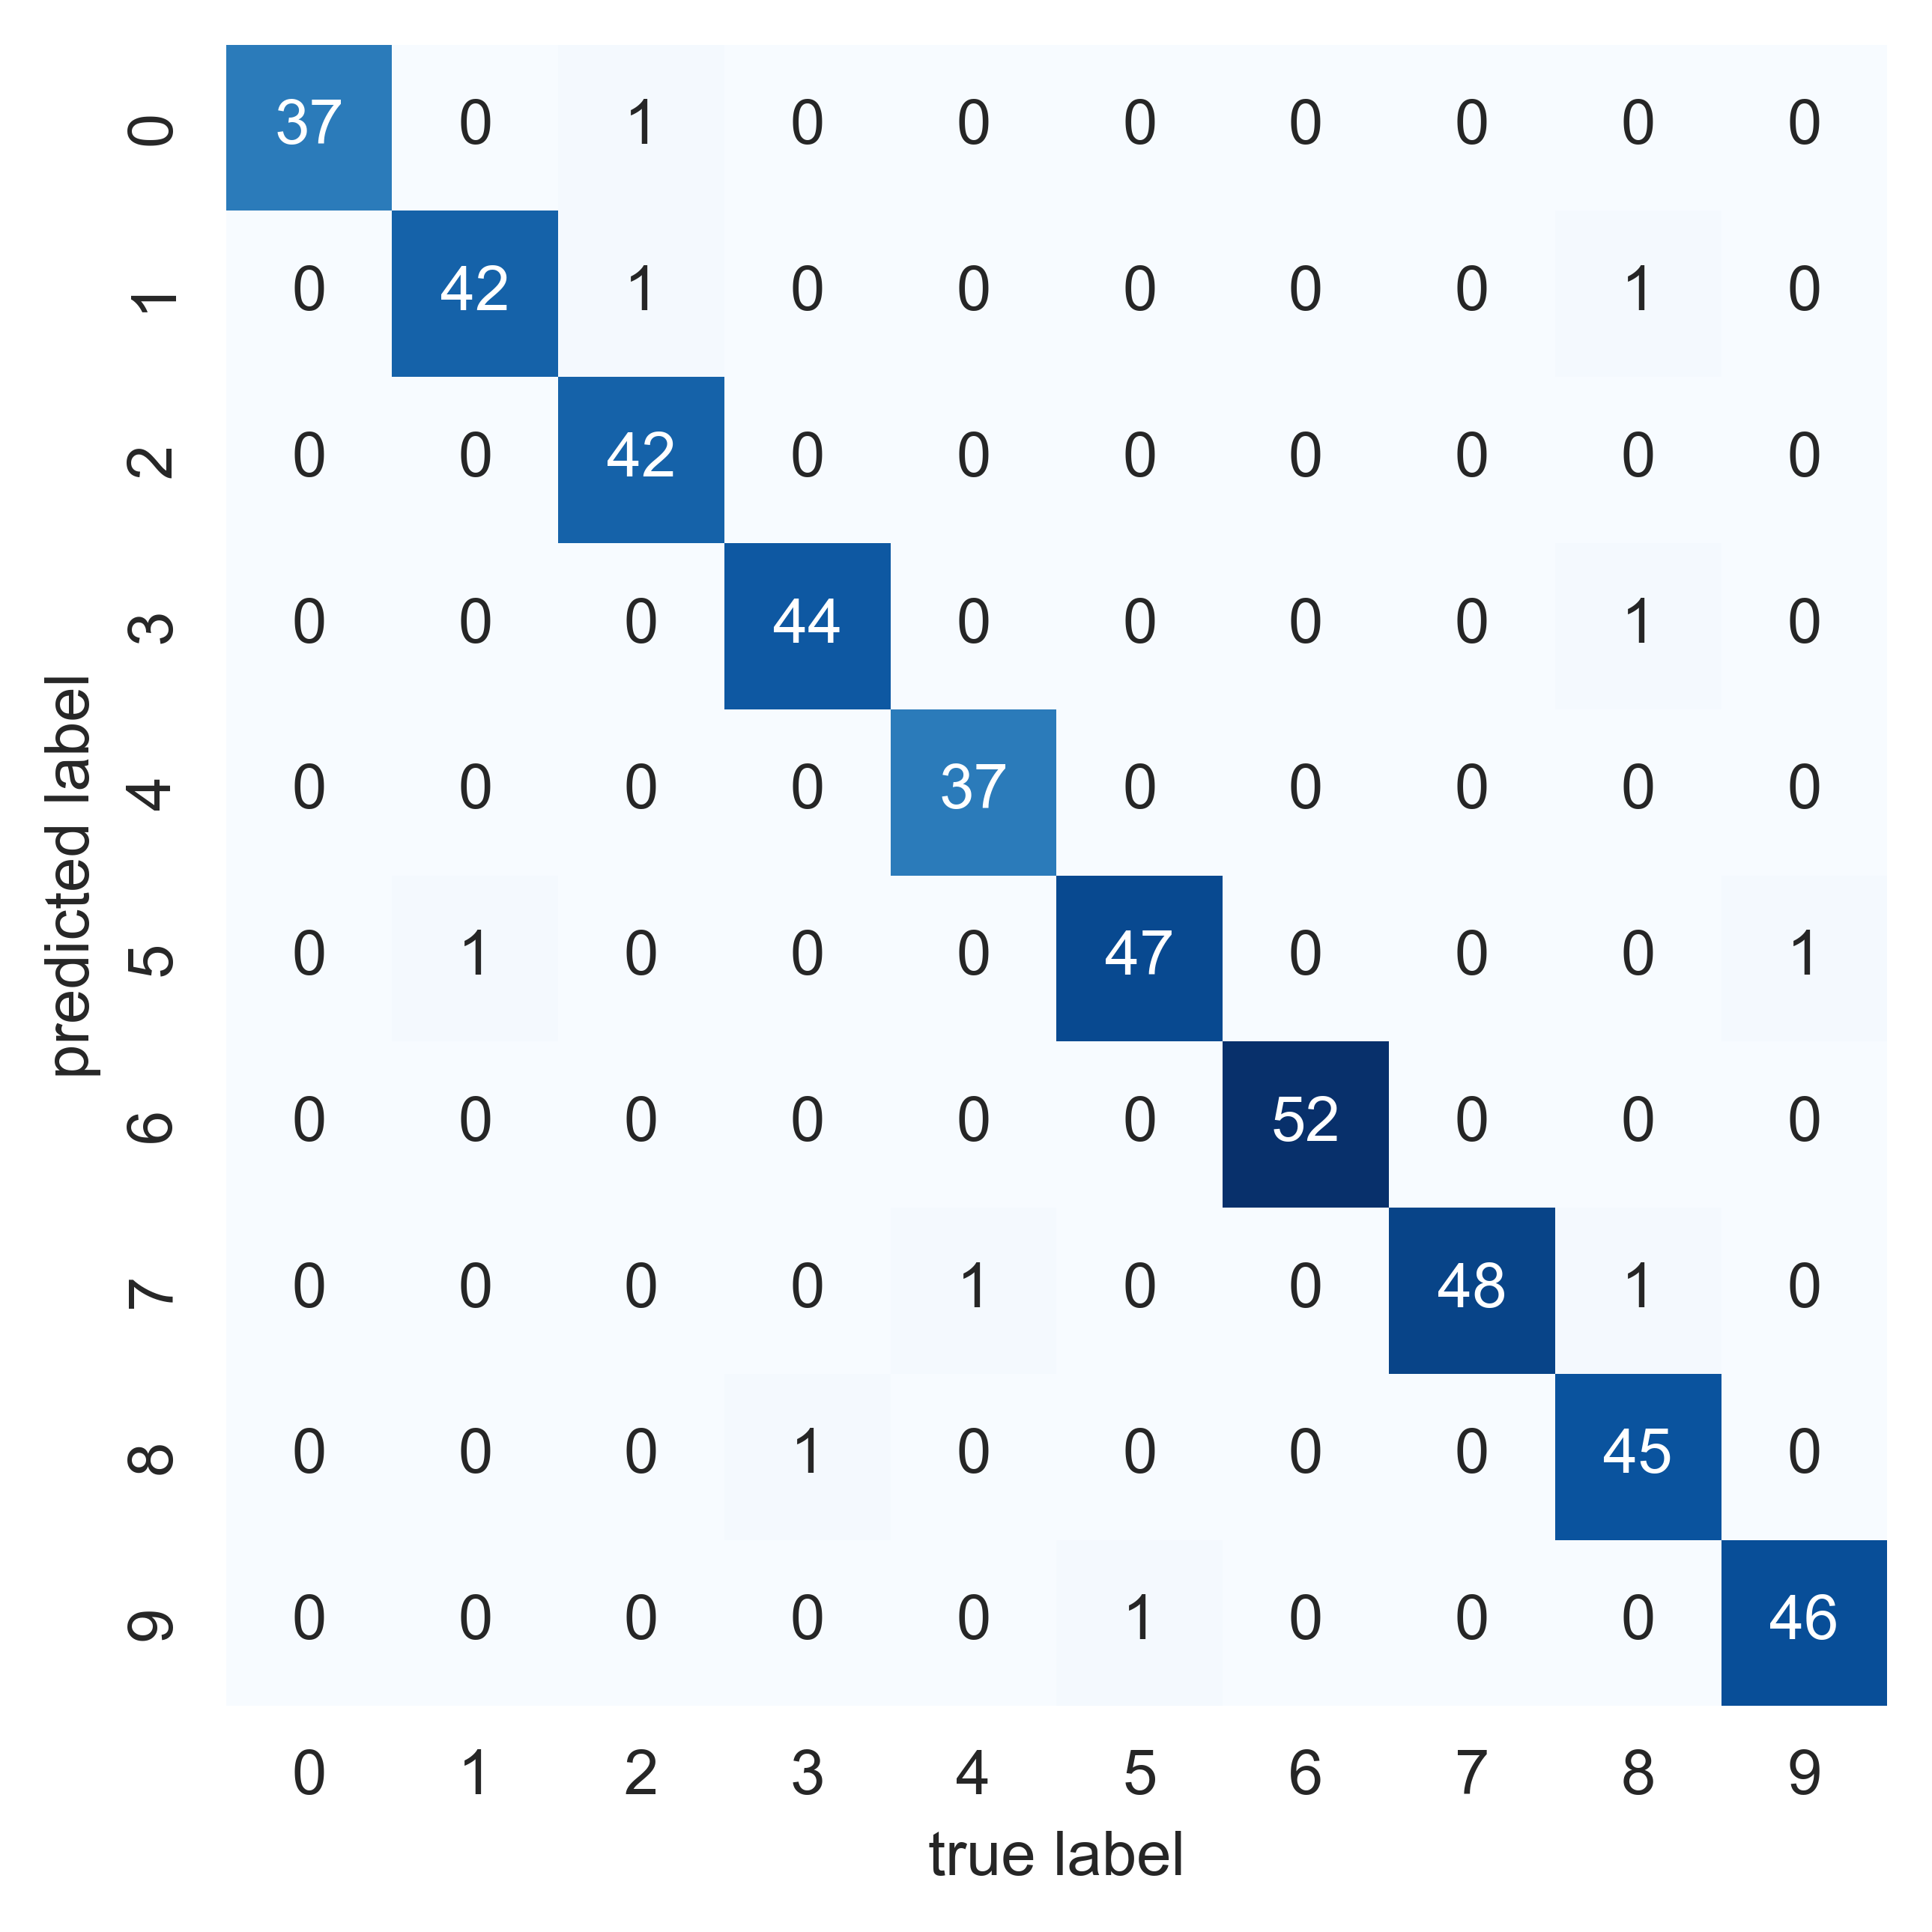

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
mat = confusion_matrix(ytest, ypred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d',
            cbar=False, cmap='Blues')
plt.xlabel('true label')
plt.ylabel('predicted label');

Encontramos que un bosque aleatorio simple y sin ajustar produce una clasificación bastante precisa de los datos de dígitos.

## Resumen

Este capítulo proporcionó una breve introducción al concepto de estimadores de ensamble (*ensemble*), y en particular al bosque aleatorio, un ensamble de árboles de decisión aleatorizados.
Los bosques aleatorios son un método potente con varias ventajas:

- Tanto el entrenamiento como la predicción son muy rápidos debido a la simplicidad de los árboles de decisión subyacentes. Además, ambas tareas pueden paralelizarse de manera sencilla, ya que los árboles individuales son entidades totalmente independientes.
- Los múltiples árboles permiten una clasificación probabilística: un voto por mayoría entre los estimadores proporciona una estimación de la probabilidad (accesible en Scikit-Learn con el método `predict_proba`).
- El modelo no paramétrico es extremadamente flexible y, por lo tanto, puede funcionar bien en tareas en las que otros estimadores sufren de subajuste (*underfitting*).

Una desventaja principal de los bosques aleatorios es que los resultados no son fácilmente interpretables: es decir, si deseas sacar conclusiones sobre el *significado* del modelo de clasificación, los bosques aleatorios pueden no ser la mejor opción.